# An Analysis of the City of Toronto’s Fire Response between 2011-2019
## by The City of Toronto Department of Pandas¶

The goal of this project is to create a predictive model capable of determining response time given inputs such as day, time, or location. Exploratory data analysis is iterative, therefore, until our exploratory data analysis is conducted, we will not know exactly which features will be used to implement the model, nor do we know exactly what type of prediction model will be used (e.g., linear regression, logistic regression, or other approaches as suitable). However, an example of our anticipated model can be seen below.

###  Objectives
The questions we hope to answer with our exploratory data analysis are:
- Are there temporal trends in factors such as response time, damages, or other relevant factors?

- Identify the characteristics of fires with extensive damage/casualties. What factors make a fire most/least likely to cause extensive damage/casualties?

- Analyze and intersect our datasets to find the closest TFS station to each fire. Stations that frequently fail to respond in a timely manner to nearby fires may require more resources from the city.

- Identify the common fire incidents and causes in each ward.

- Optional: Is there a correlation between the resources TFS deploys (number of personnel, vehicles, etc.) during incidents and damages (such as casualties/financial)?

- Optional: Overlay incidents with socio-economic profiles of each neighborhood and analyze whether TFS services are equally and equitably distributed across the city. Are TFS services biased when responding to certain incidents or wards of the city?

## Setup Notebook

In [2]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import 3rd party libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from scipy.stats import chi2_contingency

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Overview

The primary dataset to be used for this project includes information about Toronto’s Fire Incidents (https://open.toronto.ca/dataset/fire-incidents/). This data is a .csv file from the City of Toronto’s open data portal with details of over 17,000 fire incidents between January 1, 2011, to June 30, 2019. The dataset contains 43 columns that describe the geographic location of the fire, the TFS response, impact of the fire, suspected cause, and details of the site (e.g., building condition and presence of sprinklers or alarms). The dataset contains categorical variables, many null values, and string values in many of the columns. Extensive data cleaning and data wrangling as well as feature engineering is needed for this project. Feature engineering techniques such as categorical encoding, datetime extraction, imputation, etc. will be used for this project. The appendix shows the data types and categories of each of the columns in the dataset.

The rest of the datasets described in this paragraph are secondary datasets that will only be used if time allows. The second dataset is the City of Toronto Wards data which includes spatial boundaries that we can overlay with the fire incident data for visualization purposes (https://open.toronto.ca/dataset/city-wards/). The third dataset is a .GeoJSON file with Toronto Fire station locations (https://open.toronto.ca/dataset/fire-station-locations/). Finally, if time allows, we will use a fourth dataset of Toronto’s neighbourhoods which includes information on variables such as income, population, household type, and education (https://open.toronto.ca/dataset/neighbourhood-profiles/).

# Import Data
Let's import the training datasets.

### Toronto Fire Incidents

In [4]:
fire_data = pd.read_csv('Fire Incidents Data.csv')

In [5]:
fire_data.head(10)

_id                                     Area_of_Origin  \
0  578689                                   81 - Engine Area   
1  578690                 75 - Trash, rubbish area (outside)   
2  578691                                                NaN   
3  578692                 75 - Trash, rubbish area (outside)   
4  578693                                                NaN   
5  578694                                   81 - Engine Area   
6  578695  22 - Sleeping Area or Bedroom (inc. patients r...   
7  578696           55 - Mechanical/Electrical Services Room   
8  578697                                        28 - Office   
9  578698                                                NaN   

           Building_Status                          Business_Impact  \
0                      NaN                                      NaN   
1                      NaN                                      NaN   
2                      NaN                                      NaN   
3  01 - Normal (no change)             1 - No business interruption   
4                      NaN                                      NaN   
5                      NaN                                      NaN   
6  01 - Normal (no change)             1 - No business interruption   
7  01 - Normal (no change)  2 - May resume operations within a week   
8  01 - Normal (no change)             1 - No business interruption   
9                      NaN                                      NaN   

   Civilian_Casualties  Count_of_Persons_Rescued  Estimated_Dollar_Loss  \
0                    0                         0                15000.0   
1                    0                         0                   50.0   
2                    0                         0                    NaN   
3                    0                         0                    0.0   
4                    0                         0                    NaN   
5                    0                         0                 1500.0   
6                    0                         0                 2000.0   
7                    0                         0               100000.0   
8                    0                         0                 5000.0   
9                    0                         0                    NaN   

   Estimated_Number_Of_Persons_Displaced  Exposures  \
0                                    NaN        NaN   
1                                    NaN        NaN   
2                                    NaN        NaN   
3                                    0.0        NaN   
4                                    NaN        NaN   
5                                    NaN        NaN   
6                                    0.0        NaN   
7                                    0.0        NaN   
8                                    0.0        NaN   
9                                    NaN        NaN   

  Ext_agent_app_or_defer_time  ...  \
0         2018-02-24T21:12:00  ...   
1         2018-02-24T21:29:42  ...   
2                         NaN  ...   
3         2018-02-25T14:19:25  ...   
4                         NaN  ...   
5         2018-02-25T18:38:00  ...   
6         2018-02-26T18:28:00  ...   
7         2018-02-27T10:57:32  ...   
8         2018-02-25T15:57:00  ...   
9                         NaN  ...   

            Smoke_Alarm_at_Fire_Origin_Alarm_Failure  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  98 - Not applicable: Alarm operated OR presenc...   
4                                                NaN   
5                                                NaN   
6  98 - Not applicable: Alarm operated OR presenc...   
7  98 - Not applicable: Alarm operated OR presenc...   
8  98 - Not applicable: Alarm operated OR presenc...   
9                                                NaN   

               Smoke_Alarm_at_Fire_Origin_Alarm_Typ

In [6]:
fire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Data columns (total 43 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   _id                                                            17536 non-null  int64  
 1   Area_of_Origin                                                 15623 non-null  object 
 2   Building_Status                                                11216 non-null  object 
 3   Business_Impact                                                11214 non-null  object 
 4   Civilian_Casualties                                            17536 non-null  int64  
 5   Count_of_Persons_Rescued                                       17536 non-null  int64  
 6   Estimated_Dollar_Loss                                          15627 non-null  float64
 7   Estimated_Number_Of_Persons_Displaced                     

### Toronto Wards

Importing the ward map for Toronto


In [7]:
ward = gpd.read_file('25-ward-model-december-2018-wgs84-latitude-longitude') #importing shapefile

# View GeoDataFrame
ward.head()
# ward.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

AREA_ID AREA_TYPE AREA_S_CD AREA_L_CD            AREA_NAME           X  \
0  2551040      WD18        16        16      Don Valley East  318237.290   
1  2551044      WD18        03        03  Etobicoke-Lakeshore  303099.474   
2  2551048      WD18        15        15      Don Valley West  314825.876   
3  2551052      WD18        23        23    Scarborough North  324522.149   
4  2551056      WD18        11        11  University-Rosedale  313306.543   

           Y  LONGITUDE   LATITUDE  \
0  4844000.0  -79.33298  43.739716   
1  4831000.0  -79.52087  43.621646   
2  4843000.0  -79.37536  43.728396   
3  4852000.0  -79.25467  43.809672   
4  4837000.0  -79.39432  43.671139   

                                            geometry  
0  POLYGON ((-79.31335 43.71699, -79.31950 43.715...  
1  POLYGON ((-79.49777 43.65198, -79.49725 43.651...  
2  POLYGON ((-79.35232 43.71573, -79.35209 43.715...  
3  POLYGON ((-79.22591 43.83960, -79.22556 43.839...  
4  POLYGON ((-79.39004 43.69050, -79.39004 43.690...

### Toronto Fire Station Locations

In [8]:
fire_stations = pd.read_csv('torontofirestation_locations.csv')
fire_stations = fire_stations.rename({'Latitude ': 'Lat', 'Longitude': 'Lon'}, axis = 1)
fire_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Station Number  85 non-null     object 
 1   Address         85 non-null     object 
 2   Lat             85 non-null     float64
 3   Lon             85 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.8+ KB


In [9]:
fire_stations_gdf = gpd.GeoDataFrame(fire_stations, geometry = gpd.points_from_xy(fire_stations.Lon, fire_stations.Lat))
fire_stations_gdf.head()
# fire_stations_gdf.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

Station Number                   Address        Lat        Lon  \
0    Station 111       3300 Bayview Avenue  43.790180 -79.393326   
1    Station 112      5700 Bathurst Street  43.776370 -79.443620   
2    Station 113     700 Seneca Hill Drive  43.793220 -79.350350   
3    Station 114       12 Canterbury Place  43.772680 -79.414960   
4    Station 115  115 Parkway Forest Drive  43.774208 -79.340829   

                     geometry  
0  POINT (-79.39333 43.79018)  
1  POINT (-79.44362 43.77637)  
2  POINT (-79.35035 43.79322)  
3  POINT (-79.41496 43.77268)  
4  POINT (-79.34083 43.77421)

Text(91.52006375671796, 0.5, 'Latitude')

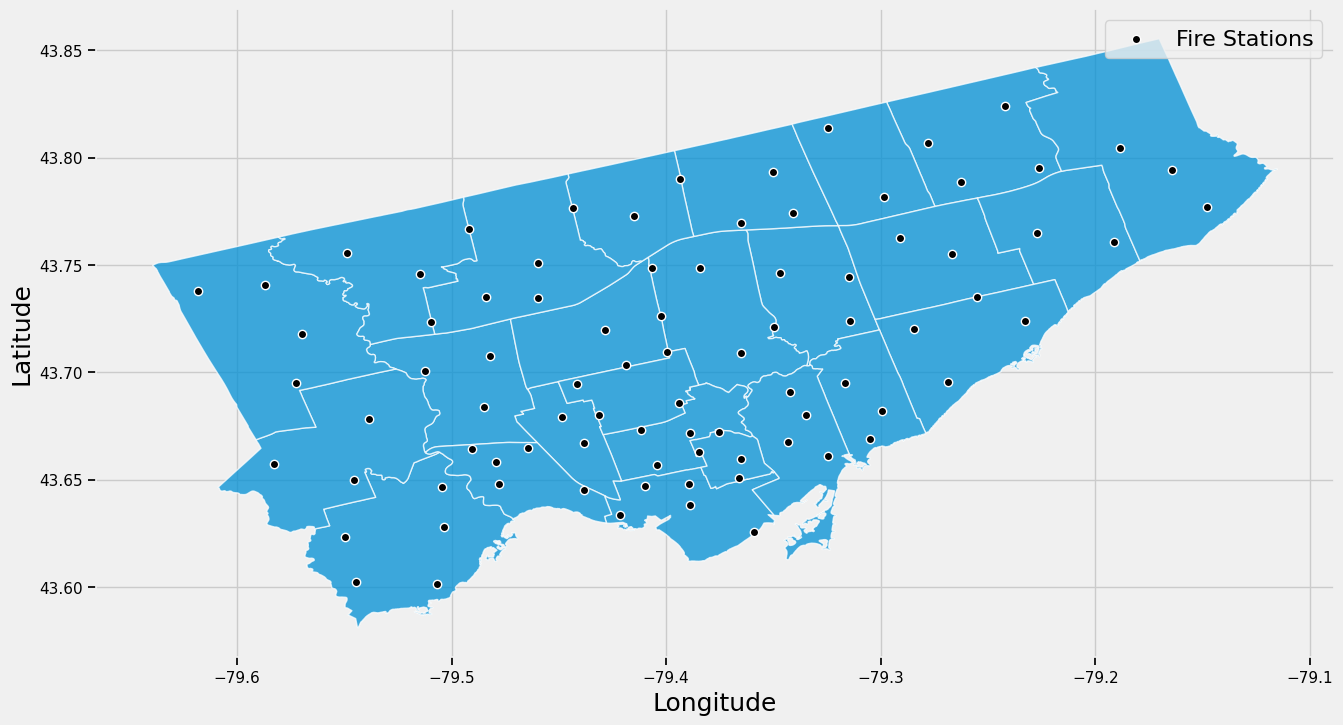

In [10]:
# Plot of the toronto fire station locations and wards
ax = ward.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)

fire_stations_gdf.plot(ax = ax, color = 'black', edgecolor = 'w', label = 'Fire Stations')

plt.legend(fontsize = 16)

plt.xlabel('Longitude', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)

# Data Cleaning

In [11]:
fire_data.head()

_id                      Area_of_Origin          Building_Status  \
0  578689                    81 - Engine Area                      NaN   
1  578690  75 - Trash, rubbish area (outside)                      NaN   
2  578691                                 NaN                      NaN   
3  578692  75 - Trash, rubbish area (outside)  01 - Normal (no change)   
4  578693                                 NaN                      NaN   

                Business_Impact  Civilian_Casualties  \
0                           NaN                    0   
1                           NaN                    0   
2                           NaN                    0   
3  1 - No business interruption                    0   
4                           NaN                    0   

   Count_of_Persons_Rescued  Estimated_Dollar_Loss  \
0                         0                15000.0   
1                         0                   50.0   
2                         0                    NaN   
3                         0                    0.0   
4                         0                    NaN   

   Estimated_Number_Of_Persons_Displaced  Exposures  \
0                                    NaN        NaN   
1                                    NaN        NaN   
2                                    NaN        NaN   
3                                    0.0        NaN   
4                                    NaN        NaN   

  Ext_agent_app_or_defer_time  ...  \
0         2018-02-24T21:12:00  ...   
1         2018-02-24T21:29:42  ...   
2                         NaN  ...   
3         2018-02-25T14:19:25  ...   
4                         NaN  ...   

            Smoke_Alarm_at_Fire_Origin_Alarm_Failure  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  98 - Not applicable: Alarm operated OR presenc...   
4                                                NaN   

  Smoke_Alarm_at_Fire_Origin_Alarm_Type  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                 9 - Type undetermined   
4                                   NaN   

  Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation  \
0                                                NaN              
1                                                NaN              
2                                                NaN              
3   8 - Not applicable: No alarm, no persons present              
4                                                NaN              

        Smoke_Spread                        Sprinkler_System_Operation  \
0                NaN                                               NaN   
1                NaN                                               NaN   
2                NaN                                               NaN   
3  99 - Undetermined  8 - Not applicable - no sprinkler system present   
4                NaN                                               NaN   

  Sprinkler_System_Presence  \
0                       NaN   
1                       NaN   
2                       NaN   
3          9 - Undetermined   
4                       NaN   

                           Status_of_Fire_On_Arrival       TFS_Alarm_Time  \
0  7 - Fully involved (total structure, vehicle, ...  2018-02-24T21:04:29   
1              2 - Fire with no evidence from street  2018-02-24T21:24:43   
2                                                NaN  2018-02-25T13:29:59   
3  3 - Fire with smoke showing only - including v...  2018-02-25T14:13:39   
4                                                NaN  2018-02-25T18:20:43   

      TFS_Arrival_Time  TFS_Firefighter_Casualties  
0  2018-02-24T21:10:11                           0  
1  2018-02-24T21:29:31                           0  
2  2018-02-25T13:36:49                           0  
3  2018-02-25T14:18:07           

In [12]:
fire_data.groupby('Material_First_Ignited').size().sort_values(ascending = False)

Material_First_Ignited
99 - Undetermined (formerly 98)                                 2390
46 - Rubbish, Trash, Waste                                      1827
74 - Cooking Oil, Grease                                        1457
47 - Vehicle                                                    1212
43 - Electrical Wiring Insulation                               1111
97 - Other                                                       954
55 - Wood                                                        533
56 - Paper, Cardboard                                            475
54 - Plastic                                                     473
14 - Interior Wall/Ceiling                                       402
23 - Cabinetry                                                   345
16 - Insulation                                                  332
21 - Upholstered Sofa, Chair, etc.                               329
31 - Mattress, Pillow                                            274
51 - Bush, 

In [13]:
fire_data.groupby('Method_Of_Fire_Control').size().sort_values(ascending = False)

Method_Of_Fire_Control
1 - Extinguished by fire department     11015
3 - Extinguished by occupant             3036
4 - Fire self extinguished                704
2 - Extinguished by automatic system      505
5 - Action taken unclassified             362
dtype: int64

## Irrelevant Data
First, we can begin by eliminating columns that we know, for sure, that we do not need. At the moment, this includes the "Incident_Number" and "Exposure" columns. "Incident_Number" because it is essentially equivalent to "_id", and "Exposure" because 98% of the data in this column are null.

In [14]:
drop = ['Area_of_Origin',
        'Building_Status',
        'Business_Impact',
        'Civilian_Casualties',
        'Count_of_Persons_Rescued',
        'Estimated_Dollar_Loss',
        'Estimated_Number_Of_Persons_Displaced',
        'Exposures',
        'Extent_Of_Fire',
        'Final_Incident_Type',
        'Fire_Alarm_System_Impact_on_Evacuation',
        'Fire_Alarm_System_Operation',
        'Fire_Alarm_System_Presence',
        'Fire_Under_Control_Time',
        'Ignition_Source',
        'Incident_Number',
        'Initial_CAD_Event_Type',
        'Intersection',
        'Last_TFS_Unit_Clear_Time',
        'Level_Of_Origin',
        'Material_First_Ignited',
        'Method_Of_Fire_Control',
        'Possible_Cause',
        'Property_Use',
        'Smoke_Alarm_at_Fire_Origin',
        'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
        'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
        'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
        'Smoke_Spread',
        'Sprinkler_System_Operation',
        'Sprinkler_System_Presence',
        'Status_of_Fire_On_Arrival',
        'Ext_agent_app_or_defer_time',
        'TFS_Firefighter_Casualties']

In [15]:
fire_data = fire_data.drop(drop, axis = 1)
fire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             17536 non-null  int64  
 1   Incident_Station_Area           17536 non-null  int64  
 2   Incident_Ward                   17451 non-null  float64
 3   Latitude                        17535 non-null  float64
 4   Longitude                       17535 non-null  float64
 5   Number_of_responding_apparatus  17536 non-null  int64  
 6   Number_of_responding_personnel  17536 non-null  int64  
 7   TFS_Alarm_Time                  17536 non-null  object 
 8   TFS_Arrival_Time                17536 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 1.2+ MB


## Missing Data
Next, it is important to understand the number of null values and how to approach eliminating or changing those values. It appears that the columns with null values are split into approximately 5 different categories.

First, we have columns missing about 36% (n = ~6300) rows of their data (mostly columns pertaining to fire alarm, smoke alarm, or sprinklers).

Second, we have columns missing about 10% (n = ~1900) rows of their data.

Third, we have one column missing 85 rows of data. This is the "Incident_Ward" column.

Fourth, we have four columns all missing 1 value. "Intersection", "Longitude", "Latitude", and "Property_Use".

Fifth, we have 12 columns with zero null values.

In [16]:
fire_data.isnull().sum().sort_values(ascending = False)

Incident_Ward                     85
Latitude                           1
Longitude                          1
_id                                0
Incident_Station_Area              0
Number_of_responding_apparatus     0
Number_of_responding_personnel     0
TFS_Alarm_Time                     0
TFS_Arrival_Time                   0
dtype: int64

In [17]:
# Finding row that the singular Latitude, Longitude, Intersection null value is in
fire_data[fire_data['Latitude'].isnull()]

_id  Incident_Station_Area  Incident_Ward  Latitude  Longitude  \
17500  596189                    214            NaN       NaN        NaN   

       Number_of_responding_apparatus  Number_of_responding_personnel  \
17500                               3                              10   

            TFS_Alarm_Time     TFS_Arrival_Time  
17500  2011-09-26T18:55:12  2011-09-26T19:01:00

In [18]:
# I decided to just drop this one, since it is only one row.
fire_data.drop(fire_data.index[17500], axis = 0, inplace = True)
fire_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17535 entries, 0 to 17535
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             17535 non-null  int64  
 1   Incident_Station_Area           17535 non-null  int64  
 2   Incident_Ward                   17451 non-null  float64
 3   Latitude                        17535 non-null  float64
 4   Longitude                       17535 non-null  float64
 5   Number_of_responding_apparatus  17535 non-null  int64  
 6   Number_of_responding_personnel  17535 non-null  int64  
 7   TFS_Alarm_Time                  17535 non-null  object 
 8   TFS_Arrival_Time                17535 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 1.3+ MB


In [19]:
# Finding rows that the 85 null Incident_Ward values are in. Is there a way for us to fill these? Why are they null? A lot seem to include "Steeles Ave"
fire_data[fire_data['Incident_Ward'].isnull()]

_id  Incident_Station_Area  Incident_Ward   Latitude  Longitude  \
211    578900                    411            NaN  43.766545 -79.564784   
214    578903                    242            NaN  43.825264 -79.300275   
565    579254                    211            NaN  43.836599 -79.251189   
1417   580106                    141            NaN  43.783218 -79.487306   
2274   580963                    113            NaN  43.808158 -79.371751   
...       ...                    ...            ...        ...        ...   
16839  595528                    344            NaN  43.679410 -79.401270   
16858  595547                    411            NaN  43.764420 -79.570960   
16925  595614                    114            NaN  43.798000 -79.420080   
17034  595723                    113            NaN  43.797450 -79.330940   
17203  595892                    313            NaN  43.667300 -79.373780   

       Number_of_responding_apparatus  Number_of_responding_personnel  \
211                                 1                               4   
214                                 1                               4   
565                                 1                               3   
1417                               10                              34   
2274                                1                               4   
...                               ...                             ...   
16839                               5                              18   
16858                              11                              34   
16925                               6                              24   
17034                               6                              21   
17203                               6                              21   

            TFS_Alarm_Time     TFS_Arrival_Time  
211    2018-01-20T06:06:46  2018-01-20T06:13:44  
214    2018-03-04T08:59:06  2018-03-04T09:05:54  
565    2018-02-12T09:01:02  2018-02-12T09:07:01  
1417   2019-01-25T18:55:30  2019-01-25T18:56:07  
2274   2019-04-21T22:16:18  2019-04-21T22:22:22  
...                    ...                  ...  
16839  2012-04-17T21:08:13  2012-04-17T21:13:00  
16858  2017-08-21T17:17:01  2017-08-21T17:23:08  
16925  2017-11-02T00:15:43  2017-11-02T00:22:44  
17034  2017-12-01T17:40:21  2017-12-01T17:46:49  
17203  2014-05-26T17:22:50  2014-05-26T17:26:59  

[84 rows x 9 columns]

In [20]:
# Decided to fill these with 0 for now. If these incident number become important, perhaps we could use lat/long to find the right incident area
fire_data['Incident_Ward'] = fire_data['Incident_Ward'].fillna(0)

## Parsing DateTimes
We have 5 columns that should be DateTimes but are currently objects. Let's convert these.

In [21]:
datetime_columns = ['TFS_Alarm_Time', 'TFS_Arrival_Time']

# 'Ext_agent_app_or_defer_time', 'Fire_Under_Control_Time', 'Last_TFS_Unit_Clear_Time'

fire_data[datetime_columns] = fire_data[datetime_columns].apply(pd.to_datetime, format = '%Y-%m-%d %H:%M:%S')
fire_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17535 entries, 0 to 17535
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   _id                             17535 non-null  int64         
 1   Incident_Station_Area           17535 non-null  int64         
 2   Incident_Ward                   17535 non-null  float64       
 3   Latitude                        17535 non-null  float64       
 4   Longitude                       17535 non-null  float64       
 5   Number_of_responding_apparatus  17535 non-null  int64         
 6   Number_of_responding_personnel  17535 non-null  int64         
 7   TFS_Alarm_Time                  17535 non-null  datetime64[ns]
 8   TFS_Arrival_Time                17535 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(4)
memory usage: 1.3 MB


In [22]:
time=fire_data['TFS_Alarm_Time'].iloc[0]
fire_data['Hour']=fire_data['TFS_Alarm_Time'].apply(lambda time:time.hour)
fire_data['Month']=fire_data['TFS_Alarm_Time'].apply(lambda time:time.month)
fire_data['Day of Week']=fire_data['TFS_Alarm_Time'].apply(lambda time:time.dayofweek)
fire_data['Year'] = fire_data['TFS_Alarm_Time'].apply(lambda time:time.year)

In [23]:
dmap={0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
fire_data['Day of Week']= fire_data['Day of Week'].map(dmap)

## Check for Duplicates

In [24]:
fire_data.duplicated().sum()

0

## Converting Incidents Data to GeoDataFrame

In [25]:
fire_data = gpd.GeoDataFrame(fire_data,
                             geometry = gpd.points_from_xy(fire_data.Longitude, fire_data.Latitude))

fire_data.head()

_id  Incident_Station_Area  Incident_Ward   Latitude  Longitude  \
0  578689                    441            1.0  43.686558 -79.599419   
1  578690                    116           18.0  43.766135 -79.390039   
2  578691                    221           21.0  43.743230 -79.245061   
3  578692                    133            5.0  43.708659 -79.478062   
4  578693                    132            8.0  43.718118 -79.443184   

   Number_of_responding_apparatus  Number_of_responding_personnel  \
0                               1                               4   
1                               1                               4   
2                               6                              22   
3                               6                              22   
4                               6                              22   

       TFS_Alarm_Time    TFS_Arrival_Time  Hour  Month Day of Week  Year  \
0 2018-02-24 21:04:29 2018-02-24 21:10:11    21      2         Sat  2018   
1 2018-02-24 21:24:43 2018-02-24 21:29:31    21      2         Sat  2018   
2 2018-02-25 13:29:59 2018-02-25 13:36:49    13      2         Sun  2018   
3 2018-02-25 14:13:39 2018-02-25 14:18:07    14      2         Sun  2018   
4 2018-02-25 18:20:43 2018-02-25 18:26:19    18      2         Sun  2018   

                     geometry  
0  POINT (-79.59942 43.68656)  
1  POINT (-79.39004 43.76613)  
2  POINT (-79.24506 43.74323)  
3  POINT (-79.47806 43.70866)  
4  POINT (-79.44318 43.71812)

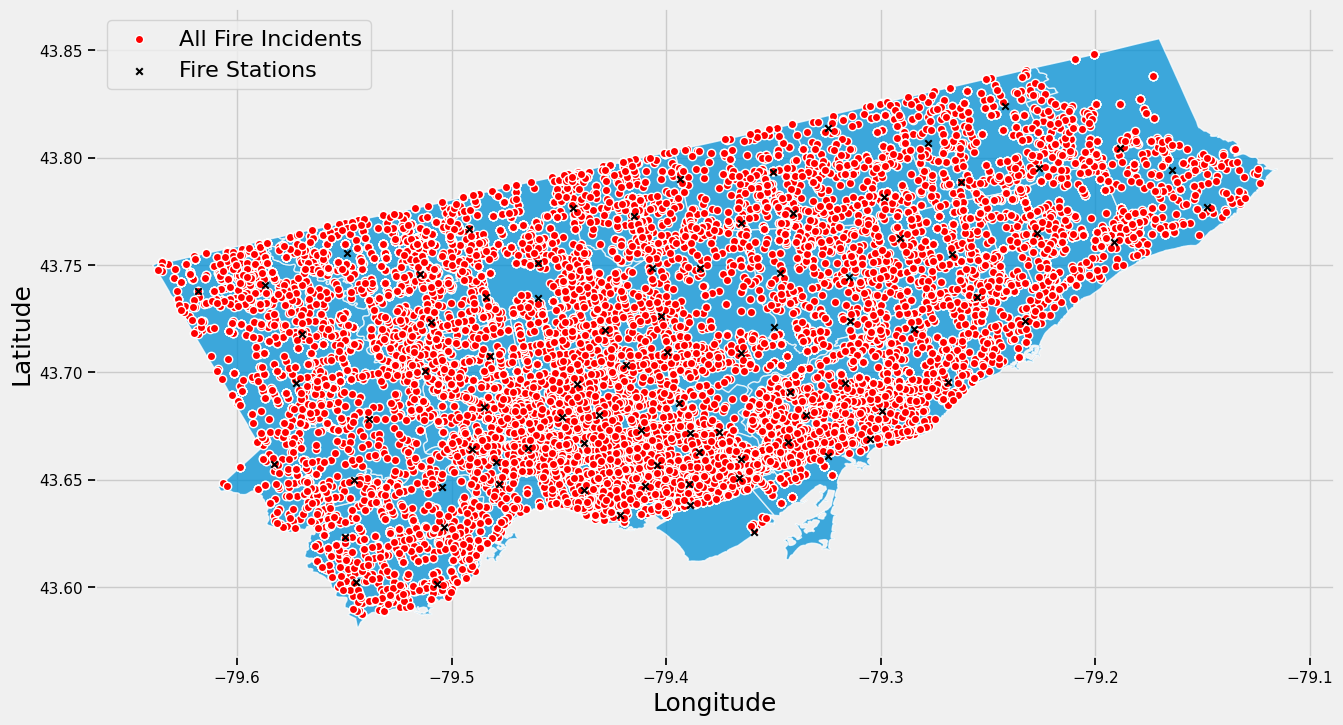

In [26]:
# Plot everything
ax = ward.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)

fire_data.plot(ax = ax, color = 'red',edgecolor = 'w', label = 'All Fire Incidents')

fire_stations_gdf.plot(ax = ax, color = 'black', marker='x',  markersize=22, edgecolor = 'w', label = 'Fire Stations')

plt.legend(fontsize = 16)

plt.xlabel('Longitude', fontsize = 18);
plt.ylabel('Latitude', fontsize = 18);

# Exploratory Data Analysis (EDA)

Target variable = response time

### Calculating Response Time

In [27]:
fire_data['response_time(min)'] =fire_data['TFS_Arrival_Time'] - fire_data['TFS_Alarm_Time']
fire_data['response_time(min)'] = fire_data['response_time(min)'].dt.total_seconds()/60

In [28]:
fire_data.head()
# Day of the week is currently the only non-numerical value

_id  Incident_Station_Area  Incident_Ward   Latitude  Longitude  \
0  578689                    441            1.0  43.686558 -79.599419   
1  578690                    116           18.0  43.766135 -79.390039   
2  578691                    221           21.0  43.743230 -79.245061   
3  578692                    133            5.0  43.708659 -79.478062   
4  578693                    132            8.0  43.718118 -79.443184   

   Number_of_responding_apparatus  Number_of_responding_personnel  \
0                               1                               4   
1                               1                               4   
2                               6                              22   
3                               6                              22   
4                               6                              22   

       TFS_Alarm_Time    TFS_Arrival_Time  Hour  Month Day of Week  Year  \
0 2018-02-24 21:04:29 2018-02-24 21:10:11    21      2         Sat  2018   
1 2018-02-24 21:24:43 2018-02-24 21:29:31    21      2         Sat  2018   
2 2018-02-25 13:29:59 2018-02-25 13:36:49    13      2         Sun  2018   
3 2018-02-25 14:13:39 2018-02-25 14:18:07    14      2         Sun  2018   
4 2018-02-25 18:20:43 2018-02-25 18:26:19    18      2         Sun  2018   

                     geometry  response_time(min)  
0  POINT (-79.59942 43.68656)            5.700000  
1  POINT (-79.39004 43.76613)            4.800000  
2  POINT (-79.24506 43.74323)            6.833333  
3  POINT (-79.47806 43.70866)            4.466667  
4  POINT (-79.44318 43.71812)            5.600000

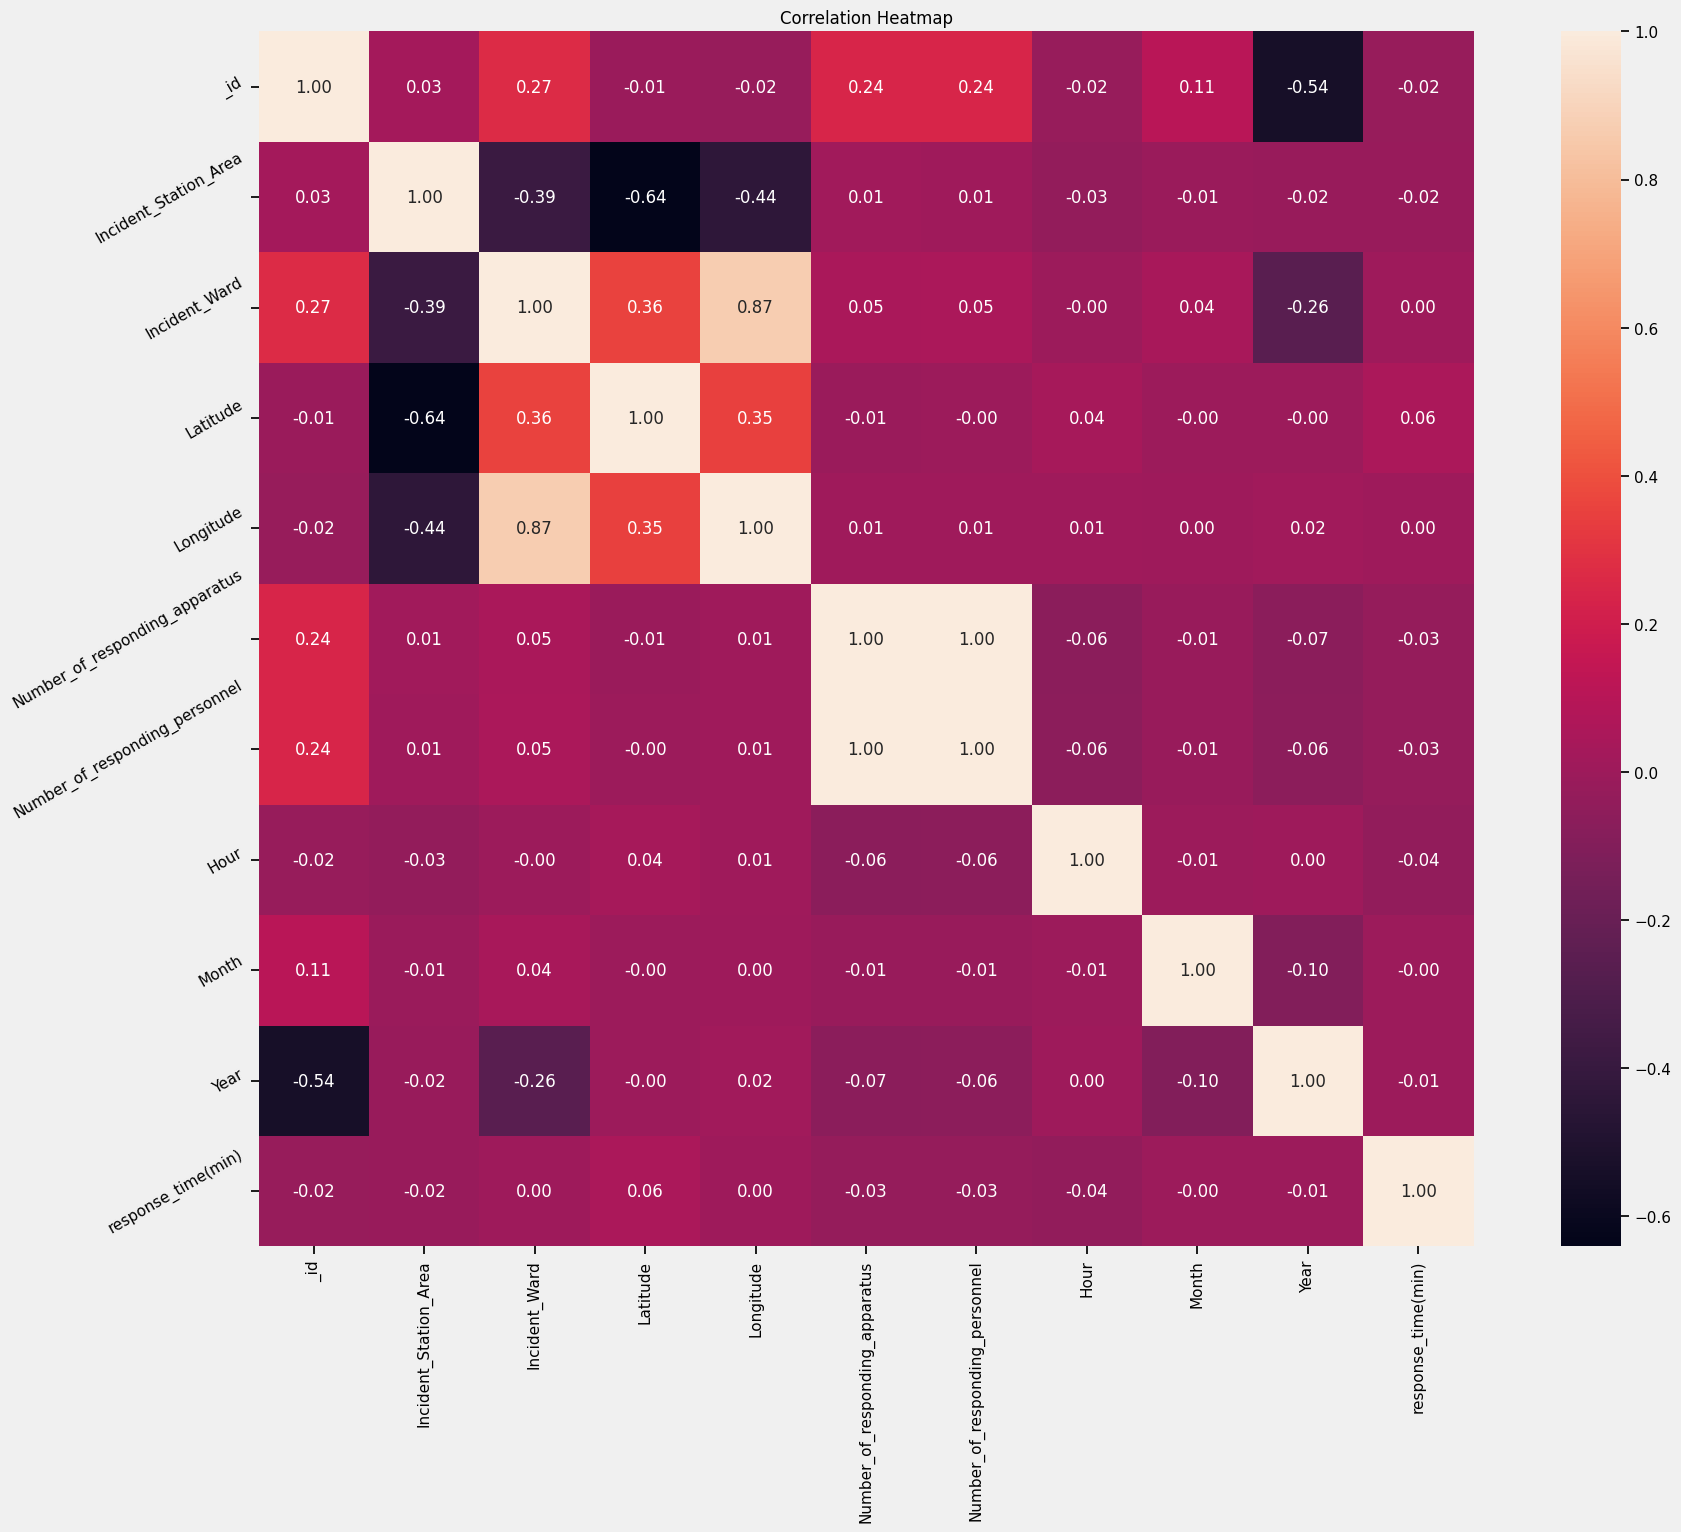

In [29]:
correlation = fire_data.corr()

#graphing the matrix
plt.figure(figsize=(20,15))
plt.title('Correlation Heatmap')#title
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
plt.show()

#### Responding  Apparatus

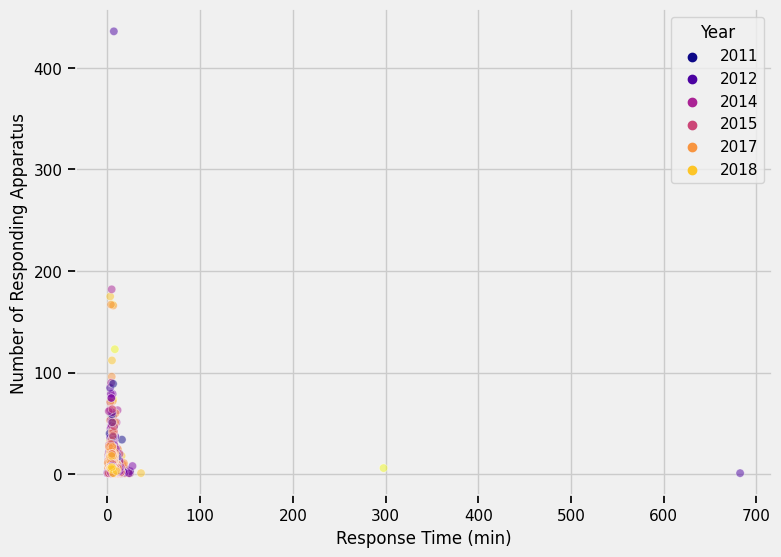

In [30]:
# Number of Apparatus
plt.figure(figsize= (8,6))
sns.scatterplot(data = fire_data,
                x = 'response_time(min)',
                y = 'Number_of_responding_apparatus',
                hue = 'Year',
                alpha = 0.5,
                palette = 'plasma')

plt.xlabel('Response Time (min)')
plt.ylabel('Number of Responding Apparatus')

plt.show()

#### Responding Personnel

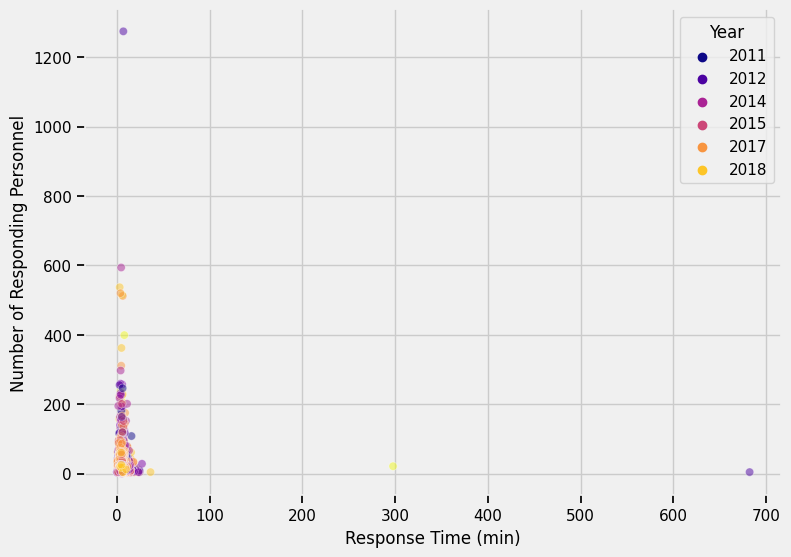

In [31]:
# Number of Personnel
plt.figure(figsize= (8,6))
sns.scatterplot(data = fire_data,
                x = 'response_time(min)',
                y = 'Number_of_responding_personnel',
                hue = 'Year',
                alpha = 0.5,
                palette = 'plasma')

plt.xlabel('Response Time (min)')
plt.ylabel('Number of Responding Personnel')

plt.show()

## Geospatial Relationships

### Distance between Incidents and Stations

In [32]:
fire_stations_gdf['Station Number Only'] = fire_stations_gdf['Station Number'].str.extract('(\d+)').astype(int)
fire_stations_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Station Number       85 non-null     object  
 1   Address              85 non-null     object  
 2   Lat                  85 non-null     float64 
 3   Lon                  85 non-null     float64 
 4   geometry             85 non-null     geometry
 5   Station Number Only  85 non-null     int32   
dtypes: float64(2), geometry(1), int32(1), object(2)
memory usage: 3.8+ KB


In [33]:
fire_data = fire_data.merge(fire_stations_gdf, left_on = 'Incident_Station_Area', right_on = 'Station Number Only')
fire_data = fire_data.rename({'Lat': 'Station_Latitude',
                              'Lon': 'Station_Longitude'})
fire_data = fire_data.drop(['Station Number', 'Address', 'Station Number Only'], axis = 1)
fire_data.head()

_id  Incident_Station_Area  Incident_Ward   Latitude  Longitude  \
0  578689                    441            1.0  43.686558 -79.599419   
1  578713                    441            1.0  43.709060 -79.587257   
2  578751                    441            2.0  43.692901 -79.554025   
3  578775                    441            1.0  43.677783 -79.574299   
4  578821                    441            2.0  43.689956 -79.563768   

   Number_of_responding_apparatus  Number_of_responding_personnel  \
0                               1                               4   
1                               3                              11   
2                              10                              36   
3                               4                              14   
4                               1                               4   

       TFS_Alarm_Time    TFS_Arrival_Time  Hour  Month Day of Week  Year  \
0 2018-02-24 21:04:29 2018-02-24 21:10:11    21      2         Sat  2018   
1 2018-01-04 20:25:55 2018-01-04 20:32:05    20      1         Thu  2018   
2 2018-01-23 08:08:00 2018-01-23 08:13:11     8      1         Tue  2018   
3 2018-03-30 02:04:03 2018-03-30 02:09:29     2      3         Fri  2018   
4 2018-02-17 10:49:37 2018-02-17 10:54:29    10      2         Sat  2018   

                   geometry_x  response_time(min)       Lat       Lon  \
0  POINT (-79.59942 43.68656)            5.700000  43.69484 -79.57237   
1  POINT (-79.58726 43.70906)            6.166667  43.69484 -79.57237   
2  POINT (-79.55403 43.69290)            5.183333  43.69484 -79.57237   
3  POINT (-79.57430 43.67778)            5.433333  43.69484 -79.57237   
4  POINT (-79.56377 43.68996)            4.866667  43.69484 -79.57237   

                   geometry_y  
0  POINT (-79.57237 43.69484)  
1  POINT (-79.57237 43.69484)  
2  POINT (-79.57237 43.69484)  
3  POINT (-79.57237 43.69484)  
4  POINT (-79.57237 43.69484)

In [34]:
from math import radians, cos, sin, asin, sqrt

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [35]:
fire_data['Incident_Station_Distance(km)'] = haversine_np(fire_data['Longitude'],
                                                                fire_data['Latitude'],
                                                                fire_data['Lon'],
                                                                fire_data['Lat'])
fire_data.head()

_id  Incident_Station_Area  Incident_Ward   Latitude  Longitude  \
0  578689                    441            1.0  43.686558 -79.599419   
1  578713                    441            1.0  43.709060 -79.587257   
2  578751                    441            2.0  43.692901 -79.554025   
3  578775                    441            1.0  43.677783 -79.574299   
4  578821                    441            2.0  43.689956 -79.563768   

   Number_of_responding_apparatus  Number_of_responding_personnel  \
0                               1                               4   
1                               3                              11   
2                              10                              36   
3                               4                              14   
4                               1                               4   

       TFS_Alarm_Time    TFS_Arrival_Time  Hour  Month Day of Week  Year  \
0 2018-02-24 21:04:29 2018-02-24 21:10:11    21      2         Sat  2018   
1 2018-01-04 20:25:55 2018-01-04 20:32:05    20      1         Thu  2018   
2 2018-01-23 08:08:00 2018-01-23 08:13:11     8      1         Tue  2018   
3 2018-03-30 02:04:03 2018-03-30 02:09:29     2      3         Fri  2018   
4 2018-02-17 10:49:37 2018-02-17 10:54:29    10      2         Sat  2018   

                   geometry_x  response_time(min)       Lat       Lon  \
0  POINT (-79.59942 43.68656)            5.700000  43.69484 -79.57237   
1  POINT (-79.58726 43.70906)            6.166667  43.69484 -79.57237   
2  POINT (-79.55403 43.69290)            5.183333  43.69484 -79.57237   
3  POINT (-79.57430 43.67778)            5.433333  43.69484 -79.57237   
4  POINT (-79.56377 43.68996)            4.866667  43.69484 -79.57237   

                   geometry_y  Incident_Station_Distance(km)  
0  POINT (-79.57237 43.69484)                       2.360284  
1  POINT (-79.57237 43.69484)                       1.981790  
2  POINT (-79.57237 43.69484)                       1.489613  
3  POINT (-79.57237 43.69484)                       1.901776  
4  POINT (-79.57237 43.69484)                       0.878794

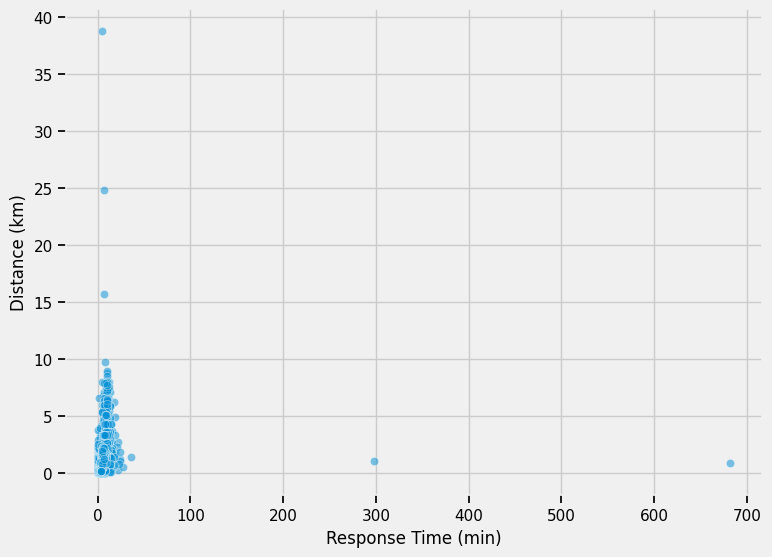

In [36]:
# Plotting distance from incident to fire station
plt.figure(figsize= (8,6))
sns.scatterplot(data = fire_data, x = 'response_time(min)', y = 'Incident_Station_Distance(km)', alpha = 0.5, palette = 'plasma')

plt.xlabel('Response Time (min)')
plt.ylabel('Distance (km)')

plt.show()

In [37]:
# Removing the outliers shown in the plot above
fire_data = fire_data[~(fire_data['response_time(min)'] > 20)]
fire_data = fire_data[~(fire_data['Incident_Station_Distance(km)'] > 10)]

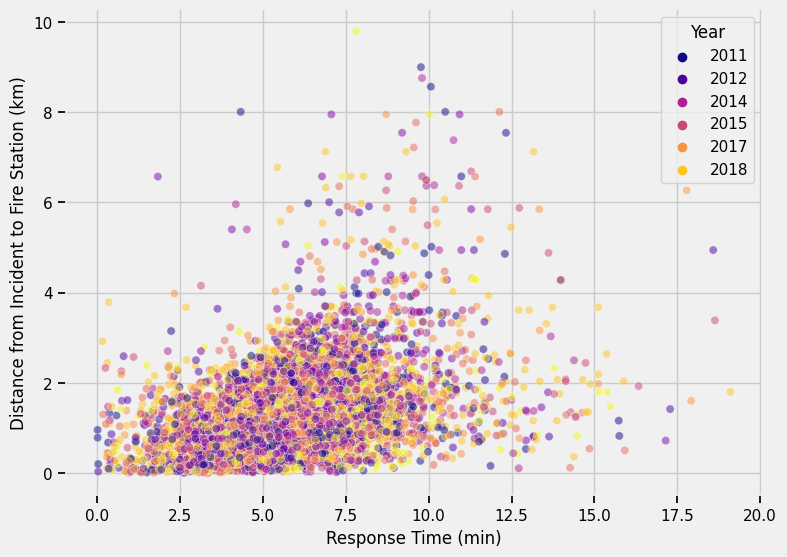

In [38]:
plt.figure(figsize= (8,6))
sns.scatterplot(data = fire_data,
                x = 'response_time(min)',
                y = 'Incident_Station_Distance(km)',
                hue = 'Year',
                alpha = 0.5,
                palette = 'plasma')

plt.xlabel('Response Time (min)')
plt.ylabel('Distance from Incident to Fire Station (km)')

plt.show()

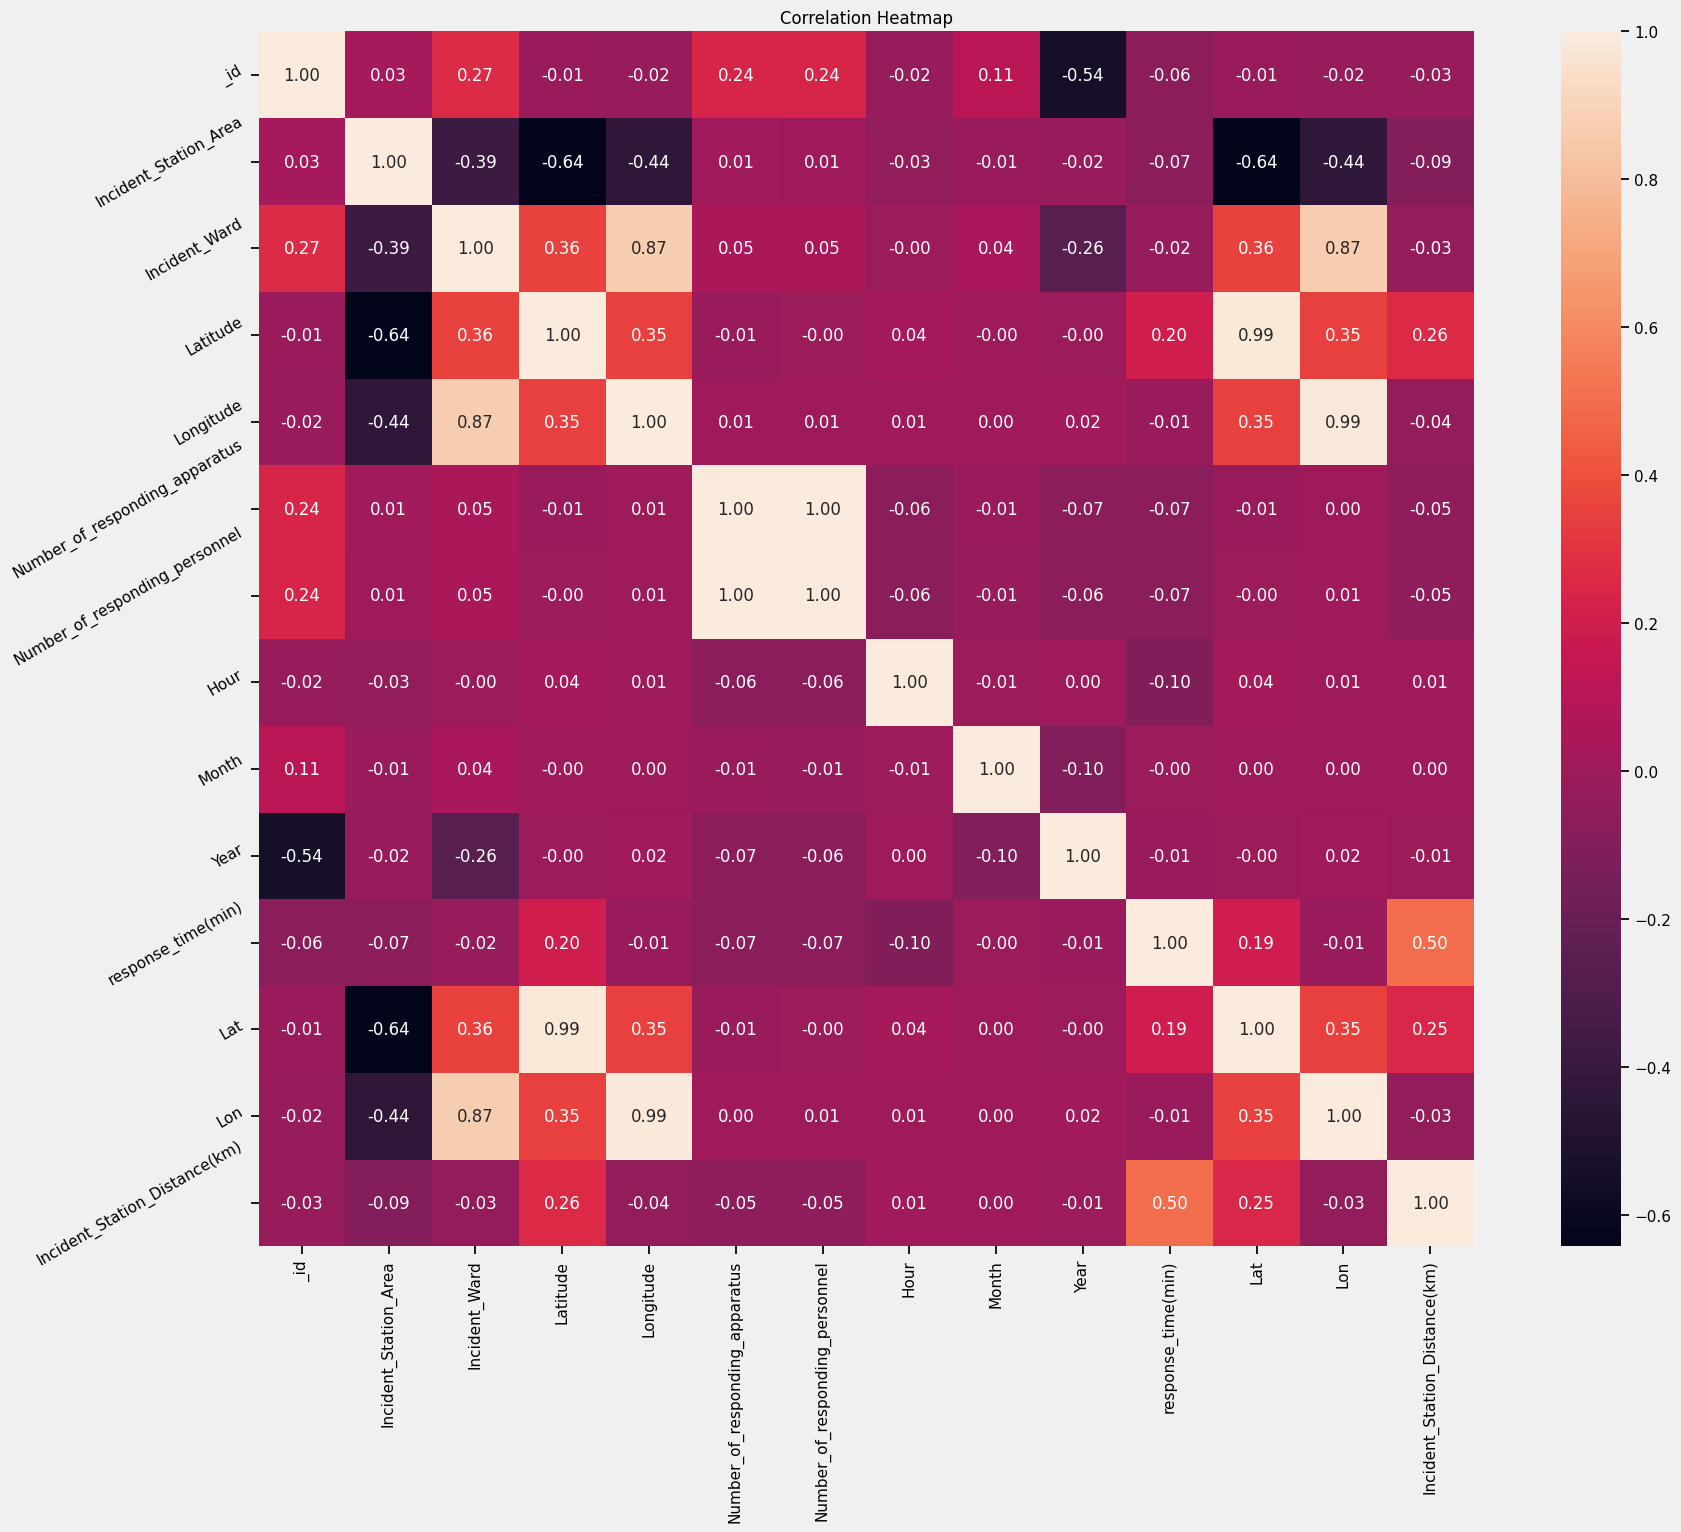

In [39]:
correlation = fire_data.corr()

#graphing the matrix
plt.figure(figsize=(20,15))
plt.title('Correlation Heatmap')#title
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
plt.show()

### Different Stations' Performance

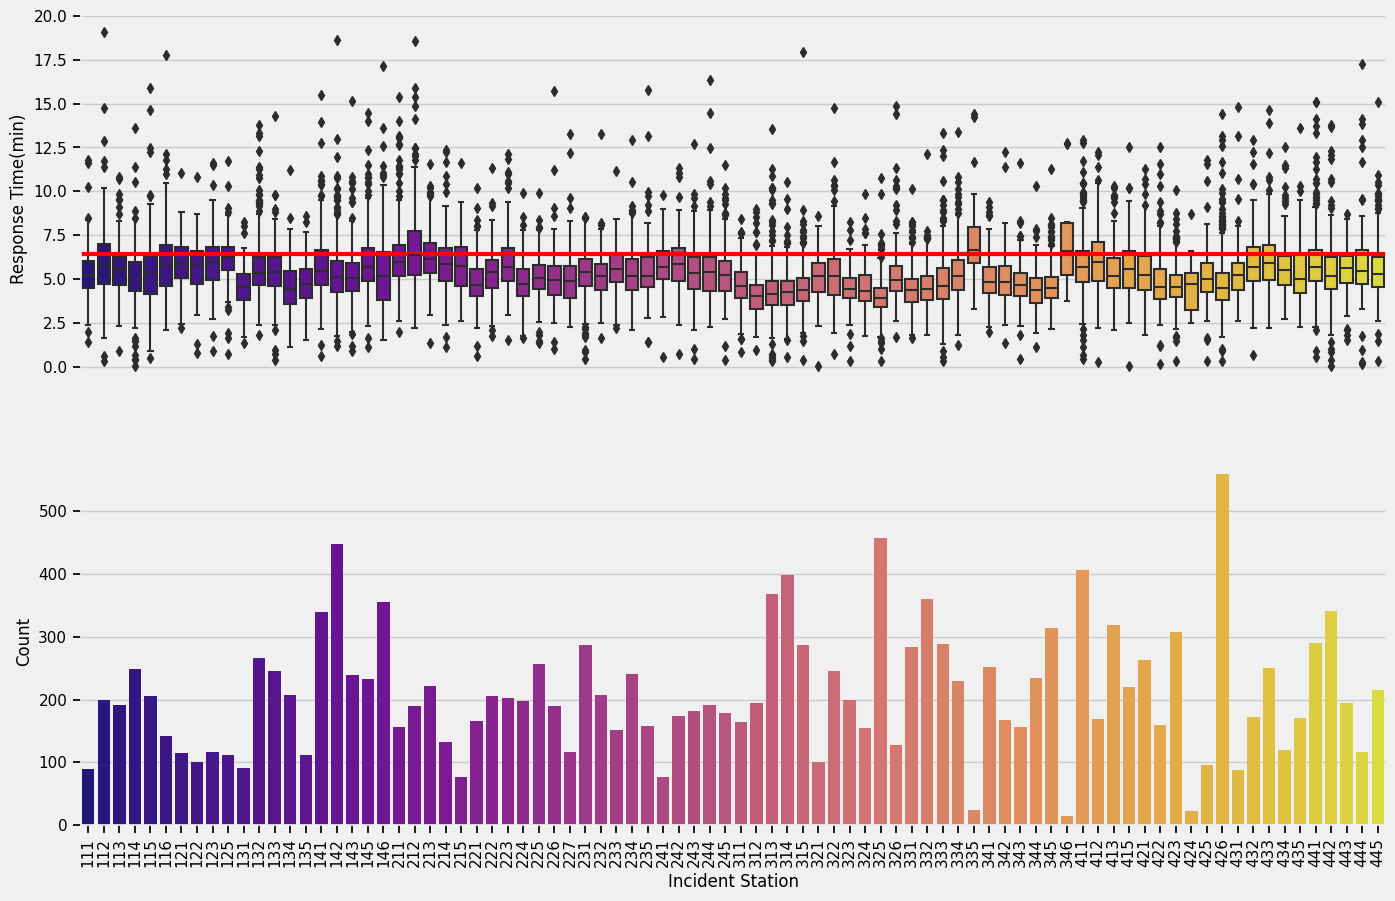

In [40]:
response_time = 6 + (24/60) #NFPA standard 6.24 min red plot

fig, axs = plt.subplots(nrows = 2, figsize = (15,10))

fig1 = sns.boxplot(data = fire_data,
            x = 'Incident_Station_Area',
            y = 'response_time(min)',palette='plasma',
           ax = axs[0])

fig1.set_ylabel('Response Time(min)')


sns.countplot(x = 'Incident_Station_Area',
             data = fire_data,palette='plasma',
             ax = axs[1])

fig2 = axs[0].axhline(y = response_time,
              color = 'red',
              linewidth=3)



axs[0].xaxis.set_visible(False)
axs[1].tick_params(axis = 'x', rotation = 90)
plt.xlabel('Incident Station')
plt.ylabel('Count')

plt.show()

### Incident Ward

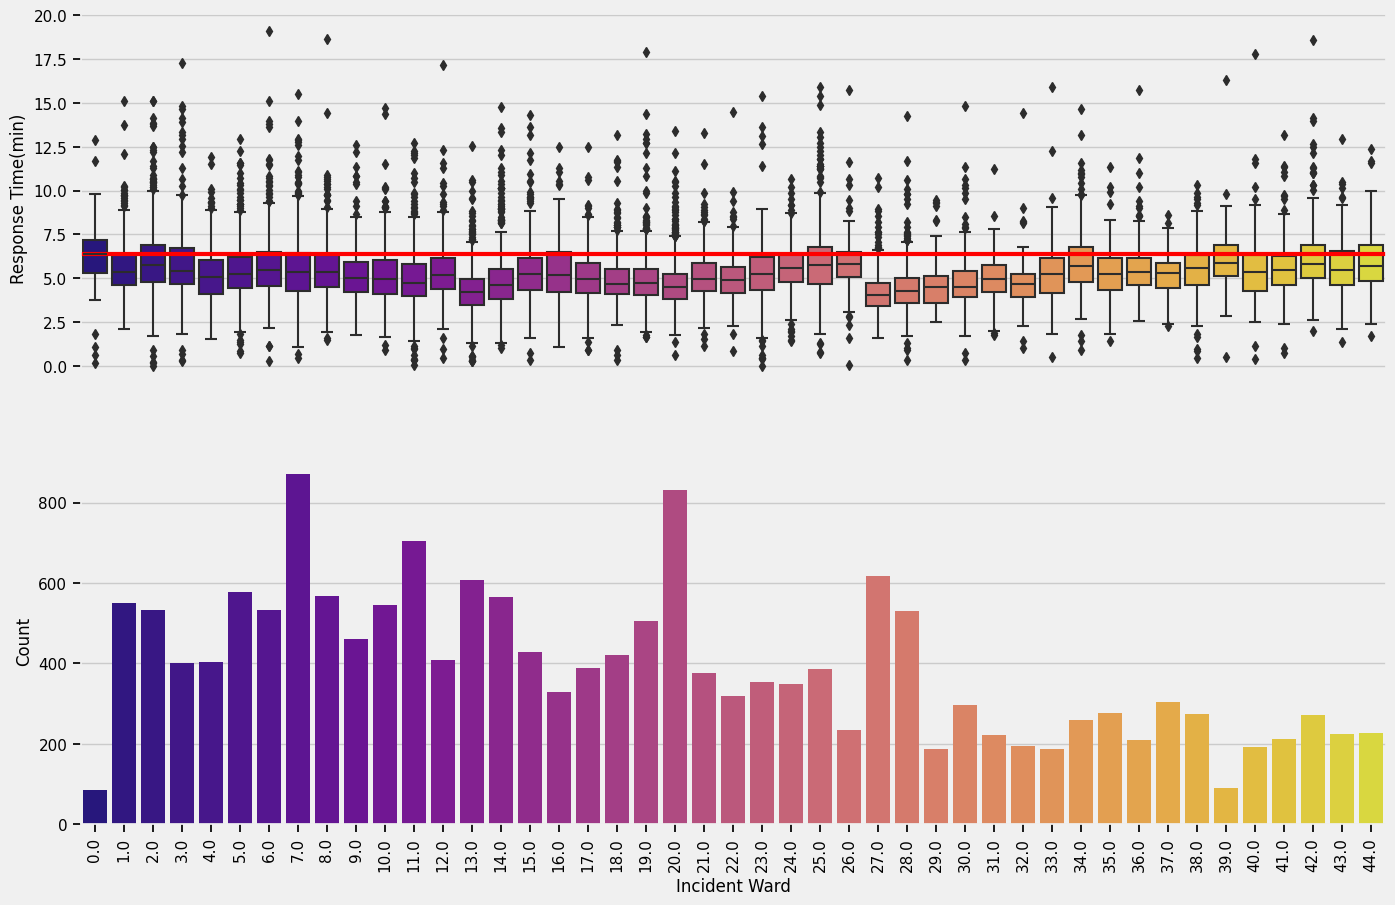

In [41]:
response_time = 6 + (24/60) #NFPA standard 6.24 min red plot

fig, axs = plt.subplots(nrows = 2, figsize = (15,10))

fig1 = sns.boxplot(data = fire_data,
            x = 'Incident_Ward',
            y = 'response_time(min)',palette='plasma',
           ax = axs[0])

fig1.set_ylabel('Response Time(min)')


sns.countplot(x = 'Incident_Ward',
             data = fire_data,palette='plasma',
             ax = axs[1])

fig2 = axs[0].axhline(y = response_time,
              color = 'red',
              linewidth=3)



axs[0].xaxis.set_visible(False)
axs[1].tick_params(axis = 'x', rotation = 90)
plt.xlabel('Incident Ward')
plt.ylabel('Count')

plt.show()

## Temporal Analysis

#### Day of Incident

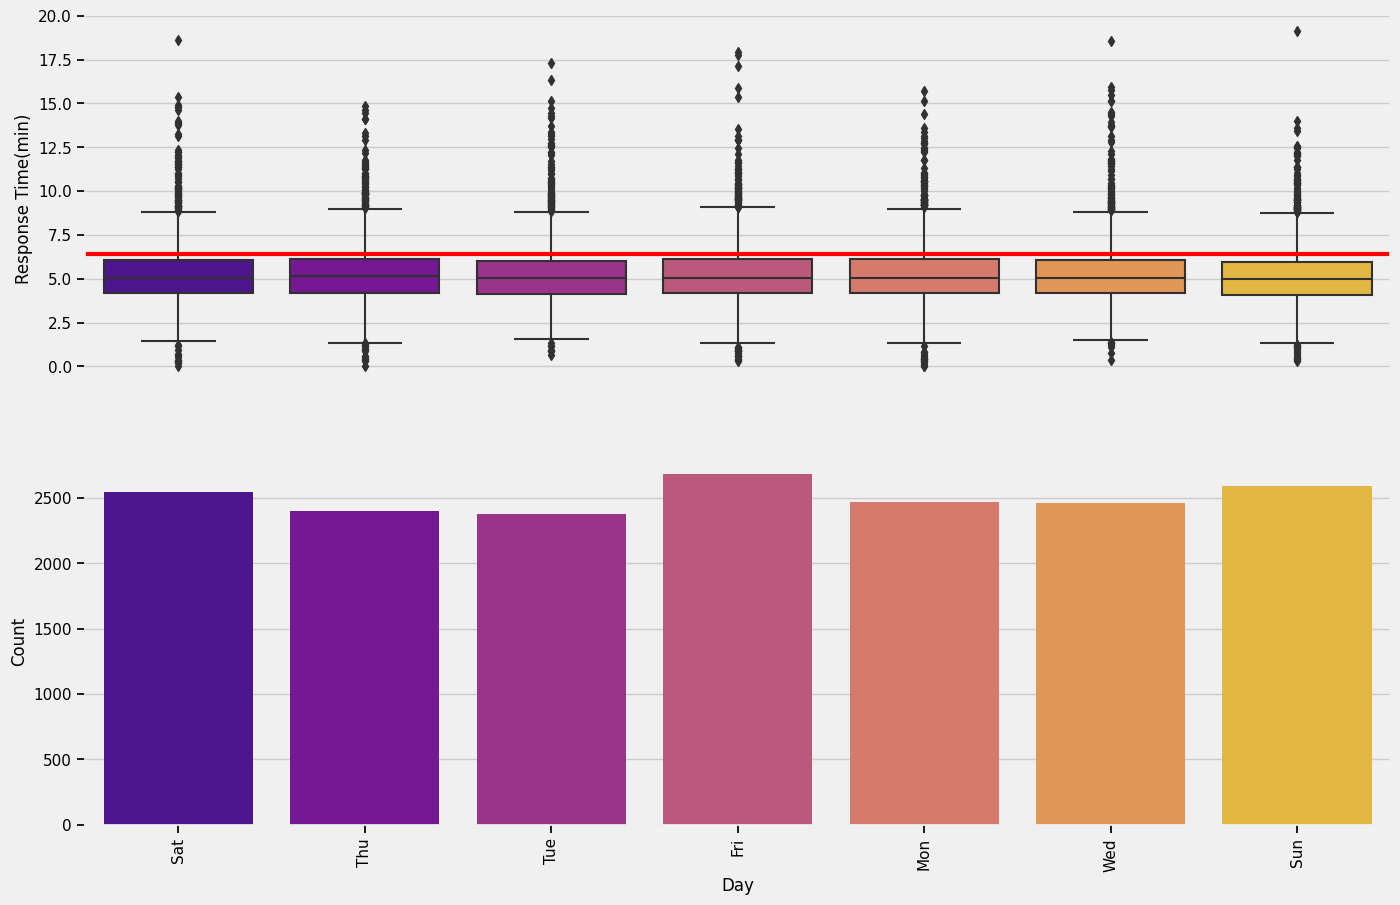

In [42]:
response_time = 6 + (24/60)  #NFPA standard 6.24 min red plot

fig, axs = plt.subplots(nrows = 2, figsize = (15,10))

fig1 = sns.boxplot(data = fire_data,
            x = 'Day of Week',
            y = 'response_time(min)',palette='plasma',
           ax = axs[0])

fig1.set_ylabel('Response Time(min)')


sns.countplot(x = 'Day of Week',
             data = fire_data,palette='plasma',
             ax = axs[1])

fig2 = axs[0].axhline(y = response_time,
              color = 'red',
              linewidth=3)



axs[0].xaxis.set_visible(False)
axs[1].tick_params(axis = 'x', rotation = 90)
plt.xlabel('Day')
plt.ylabel('Count')

plt.show()

Takeaways: Days which are more likely to have incidents are:
- Friday
- Sunday
- Saturday
- Monday

#### Month

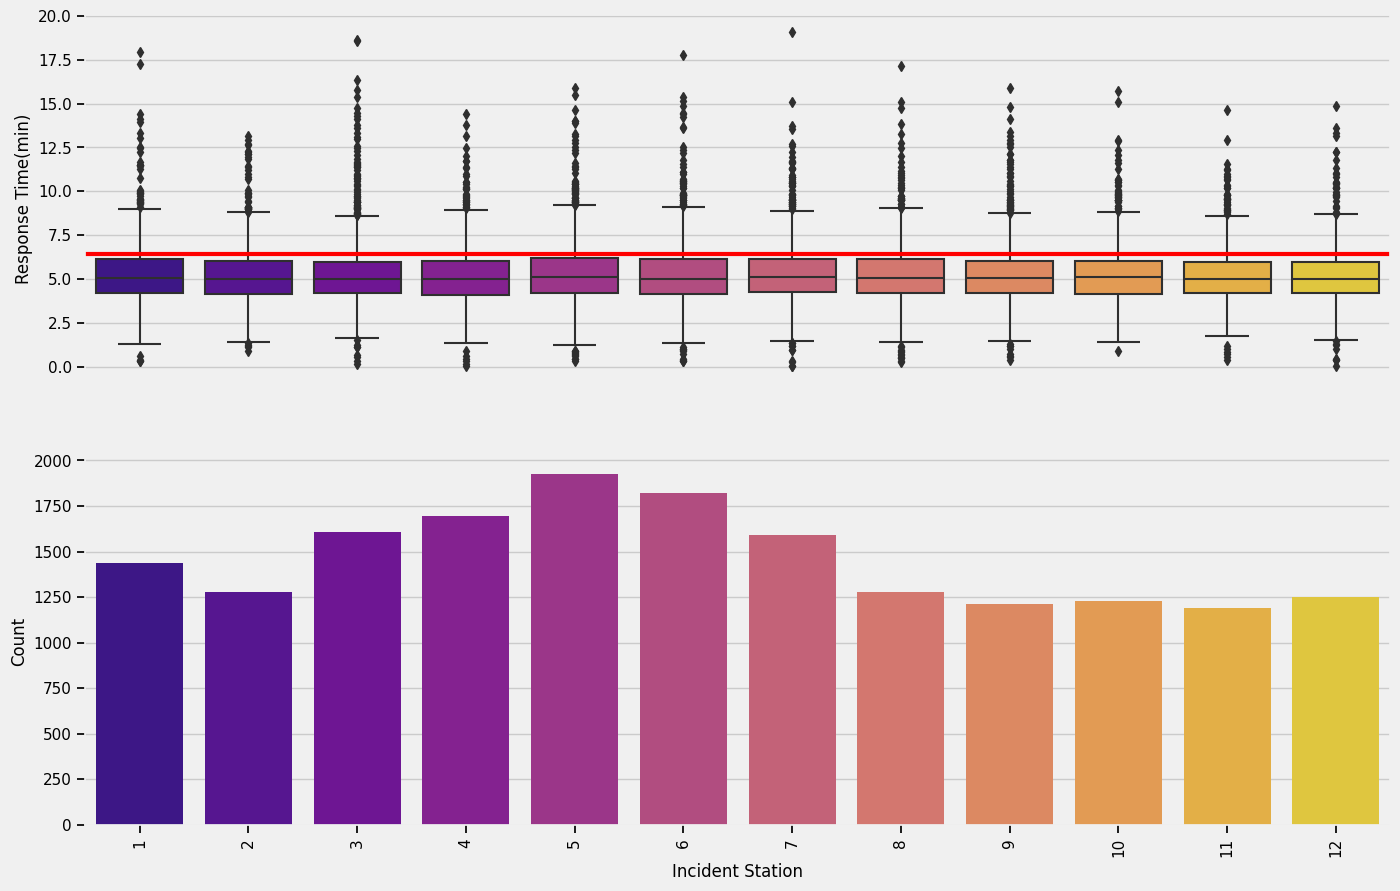

In [43]:
response_time = 6 + (24/60)

fig, axs = plt.subplots(nrows = 2, figsize = (15,10))

fig1 = sns.boxplot(data = fire_data,
            x = 'Month',
            y = 'response_time(min)',palette='plasma',
           ax = axs[0])

fig1.set_ylabel('Response Time(min)')


sns.countplot(x = 'Month',
             data = fire_data,palette='plasma',
             ax = axs[1])

fig2 = axs[0].axhline(y = response_time,
              color = 'red',
              linewidth=3)



axs[0].xaxis.set_visible(False)
axs[1].tick_params(axis = 'x', rotation = 90)
plt.xlabel('Incident Station')
plt.ylabel('Count')

plt.show()

#### Year

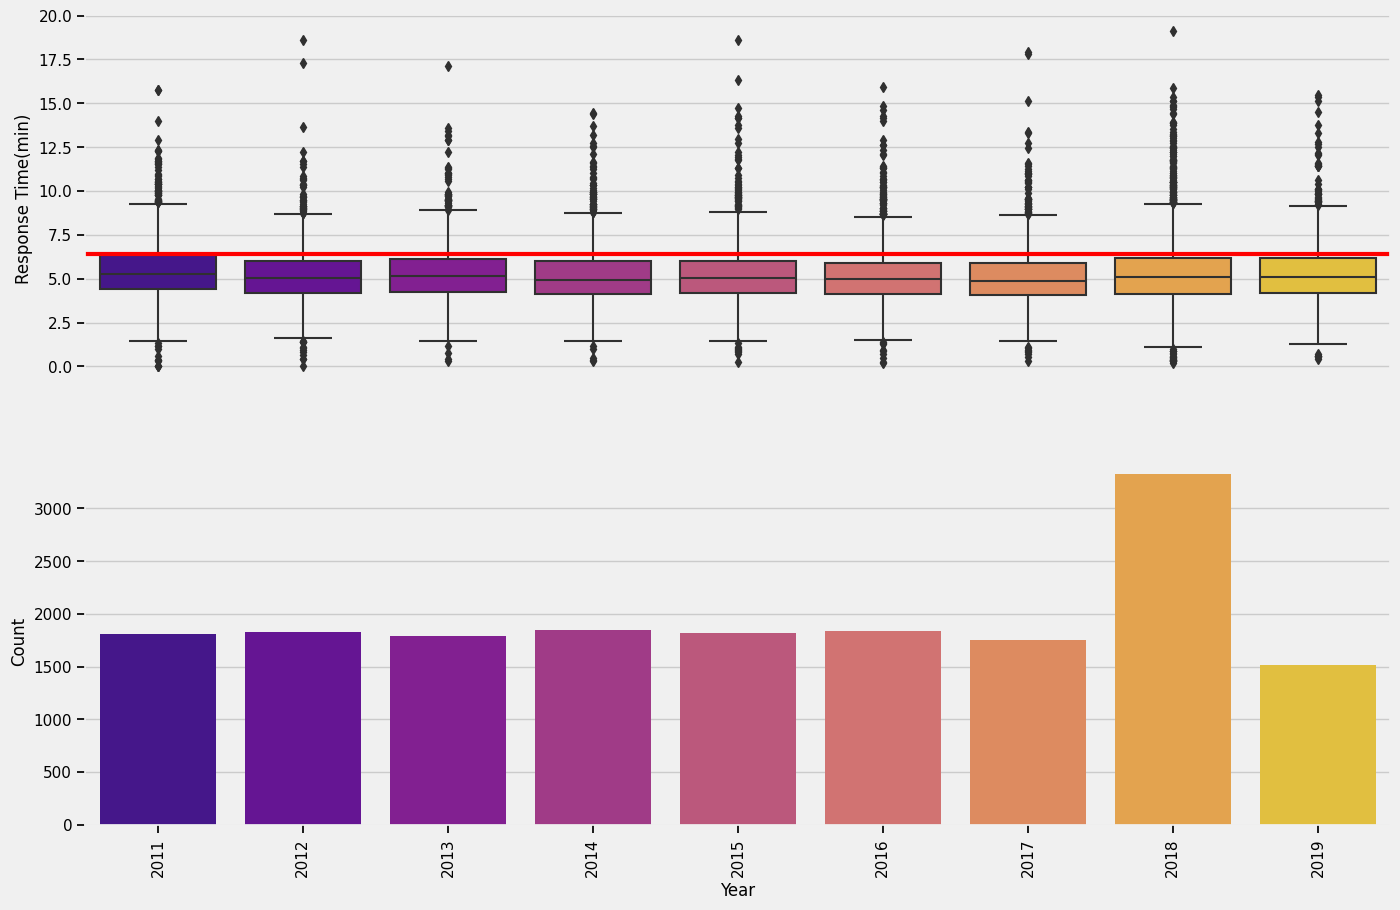

In [44]:
response_time = 6 + (24/60)

fig, axs = plt.subplots(nrows = 2, figsize = (15,10))

fig1 = sns.boxplot(data = fire_data,
            x = 'Year',
            y = 'response_time(min)',palette='plasma',
           ax = axs[0])

fig1.set_ylabel('Response Time(min)')


sns.countplot(x = 'Year',
             data = fire_data,palette='plasma',
             ax = axs[1])

fig2 = axs[0].axhline(y = response_time,
              color = 'red',
              linewidth=3)



axs[0].xaxis.set_visible(False)
axs[1].tick_params(axis = 'x', rotation = 90)
plt.xlabel('Year')
plt.ylabel('Count')

plt.show()

#### Hour

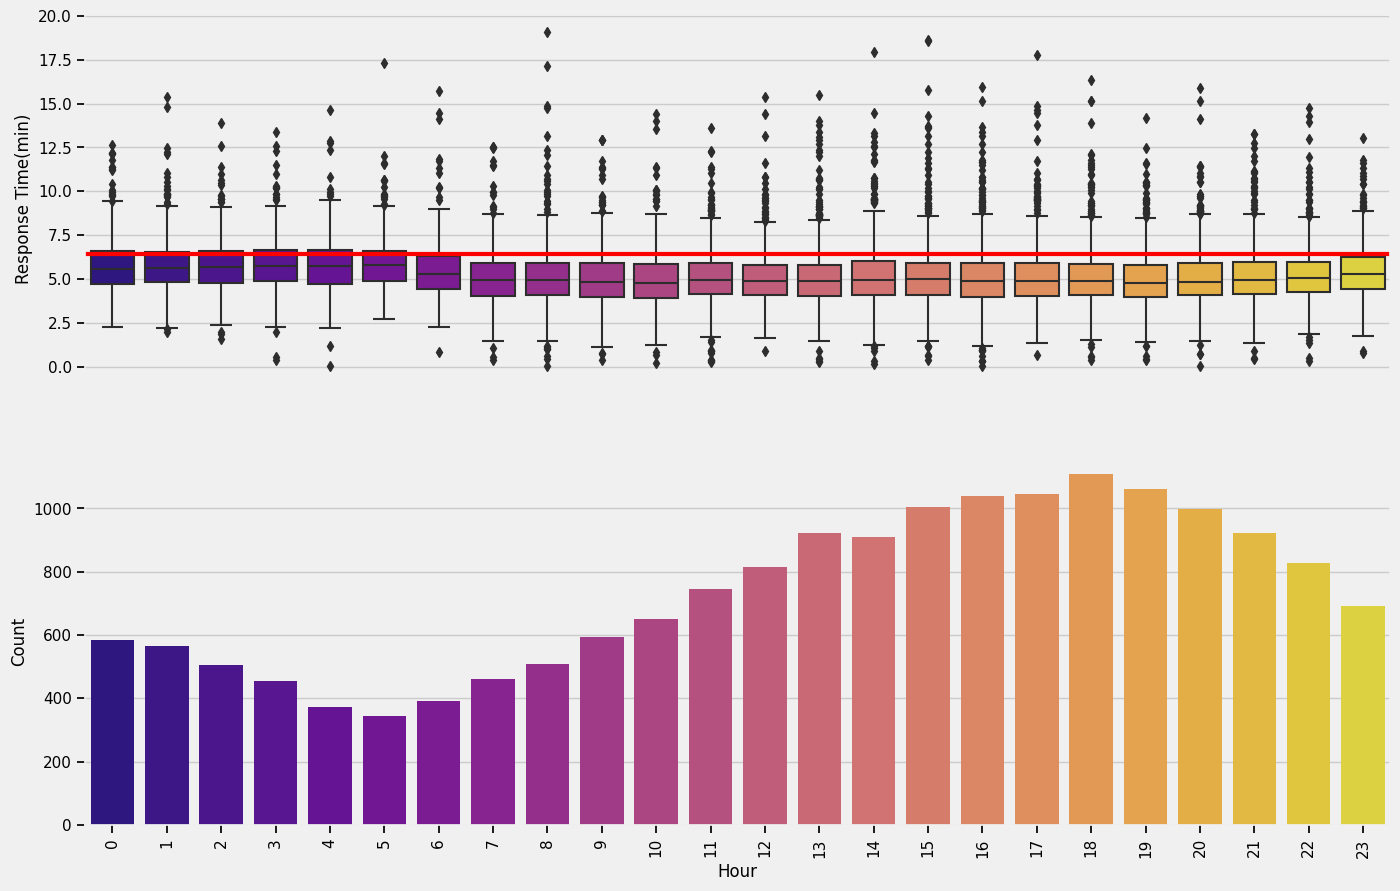

In [45]:

response_time = 6 + (24/60)

fig, axs = plt.subplots(nrows = 2, figsize = (15,10))

fig1 = sns.boxplot(data = fire_data,
            x = 'Hour',
            y = 'response_time(min)',palette='plasma',
           ax = axs[0])

fig1.set_ylabel('Response Time(min)')


sns.countplot(x = 'Hour',
             data = fire_data,palette='plasma',
             ax = axs[1])

fig2 = axs[0].axhline(y = response_time,
              color = 'red',
              linewidth=3)



axs[0].xaxis.set_visible(False)
axs[1].tick_params(axis = 'x', rotation = 90)
plt.xlabel('Hour')
plt.ylabel('Count')

plt.show()

### Income Level of Wards

In [46]:
eco_data = pd.read_csv('2018-ward-profiles-2011-2016-census-25-ward-model-data.csv')

FileNotFoundError: [Errno 2] No such file or directory: '2018-ward-profiles-2011-2016-census-25-ward-model-data.csv'

In [ ]:
eco_data.head()

City of Toronto Profiles Unnamed: 1 Unnamed: 2  \
0                       City of Toronto: City Wards         NaN        NaN   
1                                        2016 Census        NaN        NaN   
2                                                NaN        NaN        NaN   
3                                           Source:         NaN        NaN   
4  Statistics Canada, 2016 Census, Custom Tabulat...        NaN        NaN   

  Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

  Unnamed: 9  ... Unnamed: 39 Unnamed: 40 Unnamed: 41 Unnamed: 42 Unnamed: 43  \
0        NaN  ...         NaN         NaN         NaN         NaN         NaN   
1        NaN  ...         NaN         NaN         NaN         NaN         NaN   
2        NaN  ...         NaN         NaN         NaN         NaN         NaN   
3        NaN  ...         NaN         NaN         NaN         NaN         NaN   
4        NaN  ...         NaN         NaN         NaN         NaN         NaN   

  Unnamed: 44 Unnamed: 45 Unnamed: 46 Unnamed: 47 Unnamed: 48  
0         NaN         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN         NaN  
2         NaN         NaN         NaN         NaN         NaN  
3         NaN         NaN         NaN         NaN         NaN  
4         NaN         NaN         NaN         NaN         NaN  

[5 rows x 49 columns]

In [ ]:
eco_dataclean = eco_data.iloc[1224]

In [ ]:
eco_dataclean = eco_dataclean.dropna()

In [ ]:
eco_dataclean.drop('City of Toronto Profiles', inplace=True)

In [ ]:
eco_dataclean.reset_index()


index     1224
0    Unnamed: 1  1112930
1    Unnamed: 2    37890
2    Unnamed: 3    45045
3    Unnamed: 4    59735
4    Unnamed: 5    50315
5    Unnamed: 6    44930
6    Unnamed: 7    39845
7    Unnamed: 8    36215
8    Unnamed: 9    44225
9   Unnamed: 10    45595
10  Unnamed: 11    67935
11  Unnamed: 12    51215
12  Unnamed: 13    53355
13  Unnamed: 14    58510
14  Unnamed: 15    46150
15  Unnamed: 16    39685
16  Unnamed: 17    38065
17  Unnamed: 18    42475
18  Unnamed: 19    49960
19  Unnamed: 20    45995
20  Unnamed: 21    41505
21  Unnamed: 22    40290
22  Unnamed: 23    36760
23  Unnamed: 24    29345
24  Unnamed: 25    35935
25  Unnamed: 26    31960

In [ ]:
eco_dataclean.reset_index(drop=True, inplace=True)

In [ ]:
eco_dataclean = pd.DataFrame(eco_dataclean)
eco_dataclean = eco_dataclean.rename(columns={1224: 'Average Income'})
eco_dataclean.index.names = ['Ward']
eco_dataclean.head()

Average Income
Ward               
0           1112930
1             37890
2             45045
3             59735
4             50315

<BarContainer object of 26 artists>

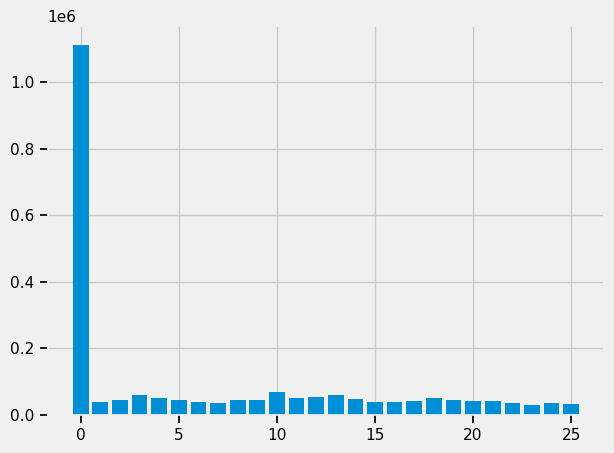

In [ ]:

eco_dataclean['Average Income'] = eco_dataclean['Average Income'].astype(int)
plt.bar(eco_dataclean.index, eco_dataclean['Average Income'])

## Predictive Model

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from sklearn import neighbors
from sklearn import tree
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import r2_score


In [65]:
fire_data

_id  Incident_Station_Area  Incident_Ward   Latitude  Longitude  \
0      578689                    441            1.0  43.686558 -79.599419   
1      578713                    441            1.0  43.709060 -79.587257   
2      578751                    441            2.0  43.692901 -79.554025   
3      578775                    441            1.0  43.677783 -79.574299   
4      578821                    441            2.0  43.689956 -79.563768   
...       ...                    ...            ...        ...        ...   
17530  593282                    424           13.0  43.651140 -79.476300   
17531  593301                    424           13.0  43.660060 -79.480020   
17532  593810                    424           13.0  43.660060 -79.480020   
17533  594791                    424           11.0  43.669190 -79.477600   
17534  595203                    424           13.0  43.660060 -79.480020   

       Number_of_responding_apparatus  Number_of_responding_personnel  \
0                                   1                               4   
1                                   3                              11   
2                                  10                              36   
3                                   4                              14   
4                                   1                               4   
...                               ...                             ...   
17530                              11                              36   
17531                              11                              37   
17532                              12                              34   
17533                              24                              78   
17534                              12                              40   

           TFS_Alarm_Time    TFS_Arrival_Time  Hour  ...  Day of Week  Year  \
0     2018-02-24 21:04:29 2018-02-24 21:10:11    21  ...          Sat  2018   
1     2018-01-04 20:25:55 2018-01-04 20:32:05    20  ...          Thu  2018   
2     2018-01-23 08:08:00 2018-01-23 08:13:11     8  ...          Tue  2018   
3     2018-03-30 02:04:03 2018-03-30 02:09:29     2  ...          Fri  2018   
4     2018-02-17 10:49:37 2018-02-17 10:54:29    10  ...          Sat  2018   
...                   ...                 ...   ...  ...          ...   ...   
17530 2012-08-17 02:14:01 2012-08-17 02:18:08     2  ...          Fri  2012   
17531 2012-08-26 11:11:53 2012-08-26 11:15:07    11  ...          Sun  2012   
17532 2011-10-10 12:28:51 2011-10-10 12:32:03    12  ...          Mon  2011   
17533 2012-02-10 21:02:10 2012-02-10 21:08:45    21  ...          Fri  2012   
17534 2014-05-26 15:06:16 2014-05-26 15:10:05    15  ...          Mon  2014   

                       geometry_x response_time(min)       Lat       Lon  \
0      POINT (-79.59942 43.68656)           5.700000  43.69484 -79.57237   
1      POINT (-79.58726 43.70906)           6.166667  43.69484 -79.57237   
2      POINT (-79.55403 43.69290)           5.183333  43.69484 -79.57237   
3      POINT (-79.57430 43.67778)           5.433333  43.69484 -79.57237   
4      POINT (-79.56377 43.68996)           4.866667  43.69484 -79.57237   
...                           ...                ...       ...       ...   
17530  POINT (-79.47630 43.65114)           4.116667  43.65844 -79.47927   
17531  POINT (-79.48002 43.66006)           3.233333  43.65844 -79.47927   
17532  POINT (-79.48002 43.66006)           3.200000  43.65844 -79.47927   
17533  POINT (-79.47760 43.66919)           6.583333  43.65844 -79.47927   
17534  POINT (-79.48002 43.66006)           3.816667  43.65844 -79.47927   

                       geometry_y Incident_Station_Distance(km)  \
0      POINT (-79.57237 43.69484)                      2.360284   
1      POINT (-79.57237 43.69484)                      1.981790   
2      POINT (-79.57237 43.69484)                      1.489613   
3      POINT (-79.57237 43.69484)                      1.901776   
4      POIN

In [66]:
#define a function to calculate the cross validated RMSE of different models

def models_rmse(models,X_train,y_train,tags):

#takes a set of training data, a list of models, and their tags, to display the cross validated RMSE of different models
    
    for model,tag in zip(models,tags):
        #evaluate the average k-fold score (RMSE) of the model
        error = ((-cross_val_score(model,X_train,y_train,scoring = 'neg_mean_squared_error',cv = 2))**0.5).mean()
        print("Root_Mean_Square_Error for %s, : %.6f"%(tag, error))

In [67]:
# Adding more features, like whether the fire occurred on a weekend or weekday, or whether the fire was in an on peak or off-peak hour
peak_hours = np.arange(12,20,1)
ward_shift_years = [2018,2019]
weekend = ['Sat','Sun']
fire_data['on_peak_hours'] = fire_data['Hour'].isin(peak_hours).astype('int')
fire_data['weekend'] = fire_data['Day of Week'].isin(weekend).astype('int')

In [68]:
# Predict response time
X = fire_data[['Incident_Station_Distance(km)','Hour', 'on_peak_hours', 'Number_of_responding_personnel', 'Number_of_responding_apparatus']]
y = fire_data[['response_time(min)']]

# standardize the data
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# split the data into train and test
# set aside 20% of train for evaluation
X_train, X_rem, y_train, y_rem = train_test_split(X_scaled, y, test_size=0.3, random_state=0)
# Create validation set
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.5, random_state=0)

models =[LinearRegression(),linear_model.Ridge(),\
             neighbors.KNeighborsRegressor(5,weights='uniform'), linear_model.BayesianRidge(),\
             tree.DecisionTreeRegressor(max_depth=4)]
tags = ["LinearRegression","Ridge", 'knn5', "BayesianRidge", 'tree4']
models_rmse(models,X_train,y_train,tags)

Root_Mean_Square_Error for LinearRegression, : 1.462858
Root_Mean_Square_Error for Ridge, : 1.462862
Root_Mean_Square_Error for knn5, : 1.533822
Root_Mean_Square_Error for BayesianRidge, : 1.462894
Root_Mean_Square_Error for tree4, : 1.440938


In [69]:
# 1 --- Building the Base Model
# Create Decision Tree classifer object
reg = tree.DecisionTreeRegressor()
# Train Decision Tree Classifer
reg = reg.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = reg.predict(X_val)

# reg = LinearRegression()
# # Train Decision Tree Classifer
# reg = reg.fit(X_train, y_train)
# #Predict the response for test dataset
# y_pred = reg.predict(X_val)

# Evaluating the model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# mean_squared_error(y_val, y_pred, squared=False)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_val, y_pred))

reg.feature_importances_

Mean Absolute Error: 1.4314821858754914
Mean Squared Error: 4.217793362495246
Root Mean Squared Error: 2.053726701023105
Mean Absolute Percentage Error: 0.4676328092067538


array([0.65881743, 0.1625361 , 0.0118226 , 0.10036285, 0.06646102])

Text(0, 0.5, 'Mean Square Error')

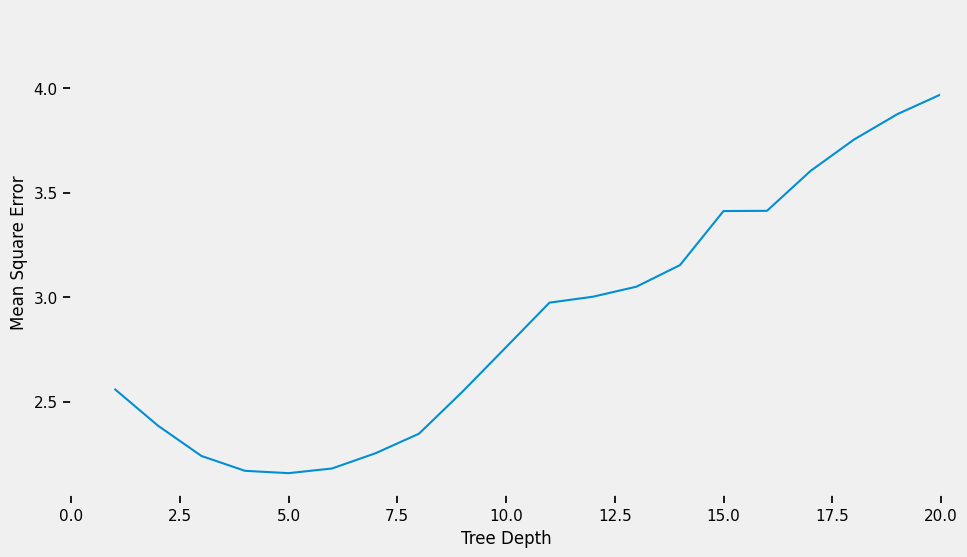

In [70]:
# Finding Optimal Depth of the tree
mses = []
for depth in range(1, (reg.tree_.max_depth + 1)):
    d_tree_reg = tree.DecisionTreeRegressor(max_depth=depth)
    d_tree_reg.fit(X_train, y_train)
    tree_predictions = d_tree_reg.predict(X_val)
    mses.append(mean_squared_error(y_val, tree_predictions))
tree_depths = [depth for depth in range(1, (reg.tree_.max_depth + 1))]
plt.figure(figsize=(10,  6))

plt.grid()
plt.plot(tree_depths, mses)
plt.xlabel("Tree Depth")
plt.xlim(0,20,1)
plt.ylabel("Mean Square Error")

In [71]:
# 2--- Create Decision Tree Regressor using optimal depth
reg = tree.DecisionTreeRegressor(max_depth=5)
# Train Decision Tree Classifer
reg = reg.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = reg.predict(X_val)

# Evaluating the model
from sklearn.metrics import mean_squared_error
# mean_squared_error(y_val, y_pred, squared=False)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_val, y_pred))

Mean Absolute Error: 1.006198058275904
Mean Squared Error: 2.157321290864217
Root Mean Squared Error: 1.468782247599765
Mean Absolute Percentage Error: 0.4128707242833458


In [72]:
# Hyper parameters range intialization for tuning 

parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5],
           "min_samples_leaf":[1,2,3,4,5,6,7],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70] }

# calculating different regression metrics
from sklearn.model_selection import GridSearchCV
grid_search=GridSearchCV(reg,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)
grid_search.fit(X_train, y_train)
# best hyperparameters 
grid_search.best_params_

Fitting 3 folds for each of 5376 candidates, totalling 16128 fits
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.474 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.406 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.428 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.875 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.931 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf

{'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': 30,
 'min_samples_leaf': 5,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

In [77]:
# 3--- Optimize Decision Tree Regressor using optimal parameters
reg = tree.DecisionTreeRegressor(max_depth=5,max_features=None,max_leaf_nodes =30, min_samples_leaf=5,min_weight_fraction_leaf=0.1,splitter='best')
# (max_depth=5, max_features='auto',max_leaf_nodes =None, min_samples_leaf=4,min_weight_fraction_leaf=0.1,splitter='best')
# Train Decision Tree Classifer
reg = reg.fit(X_train, y_train)
#Predict the response for validation dataset
y_pred = reg.predict(X_val)

# Evaluating the model
from sklearn.metrics import mean_squared_error
# mean_squared_error(y_val, y_pred, squared=False)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_val, y_pred))

Mean Absolute Error: 1.0580911819523462
Mean Squared Error: 2.3175121194827883
Root Mean Squared Error: 1.522337715319038
Mean Absolute Percentage Error: 0.4169082885757522


In [78]:
#Predict the response for test dataset
y_pred_test = reg.predict(X_test)

# Evaluating the model
from sklearn.metrics import mean_squared_error
# mean_squared_error(y_val, y_pred, squared=False)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred_test))

Mean Absolute Error: 0.9941161884017108
Mean Squared Error: 2.0402415646939085
Root Mean Squared Error: 1.428370247762781
Mean Absolute Percentage Error: 0.20785622471483098


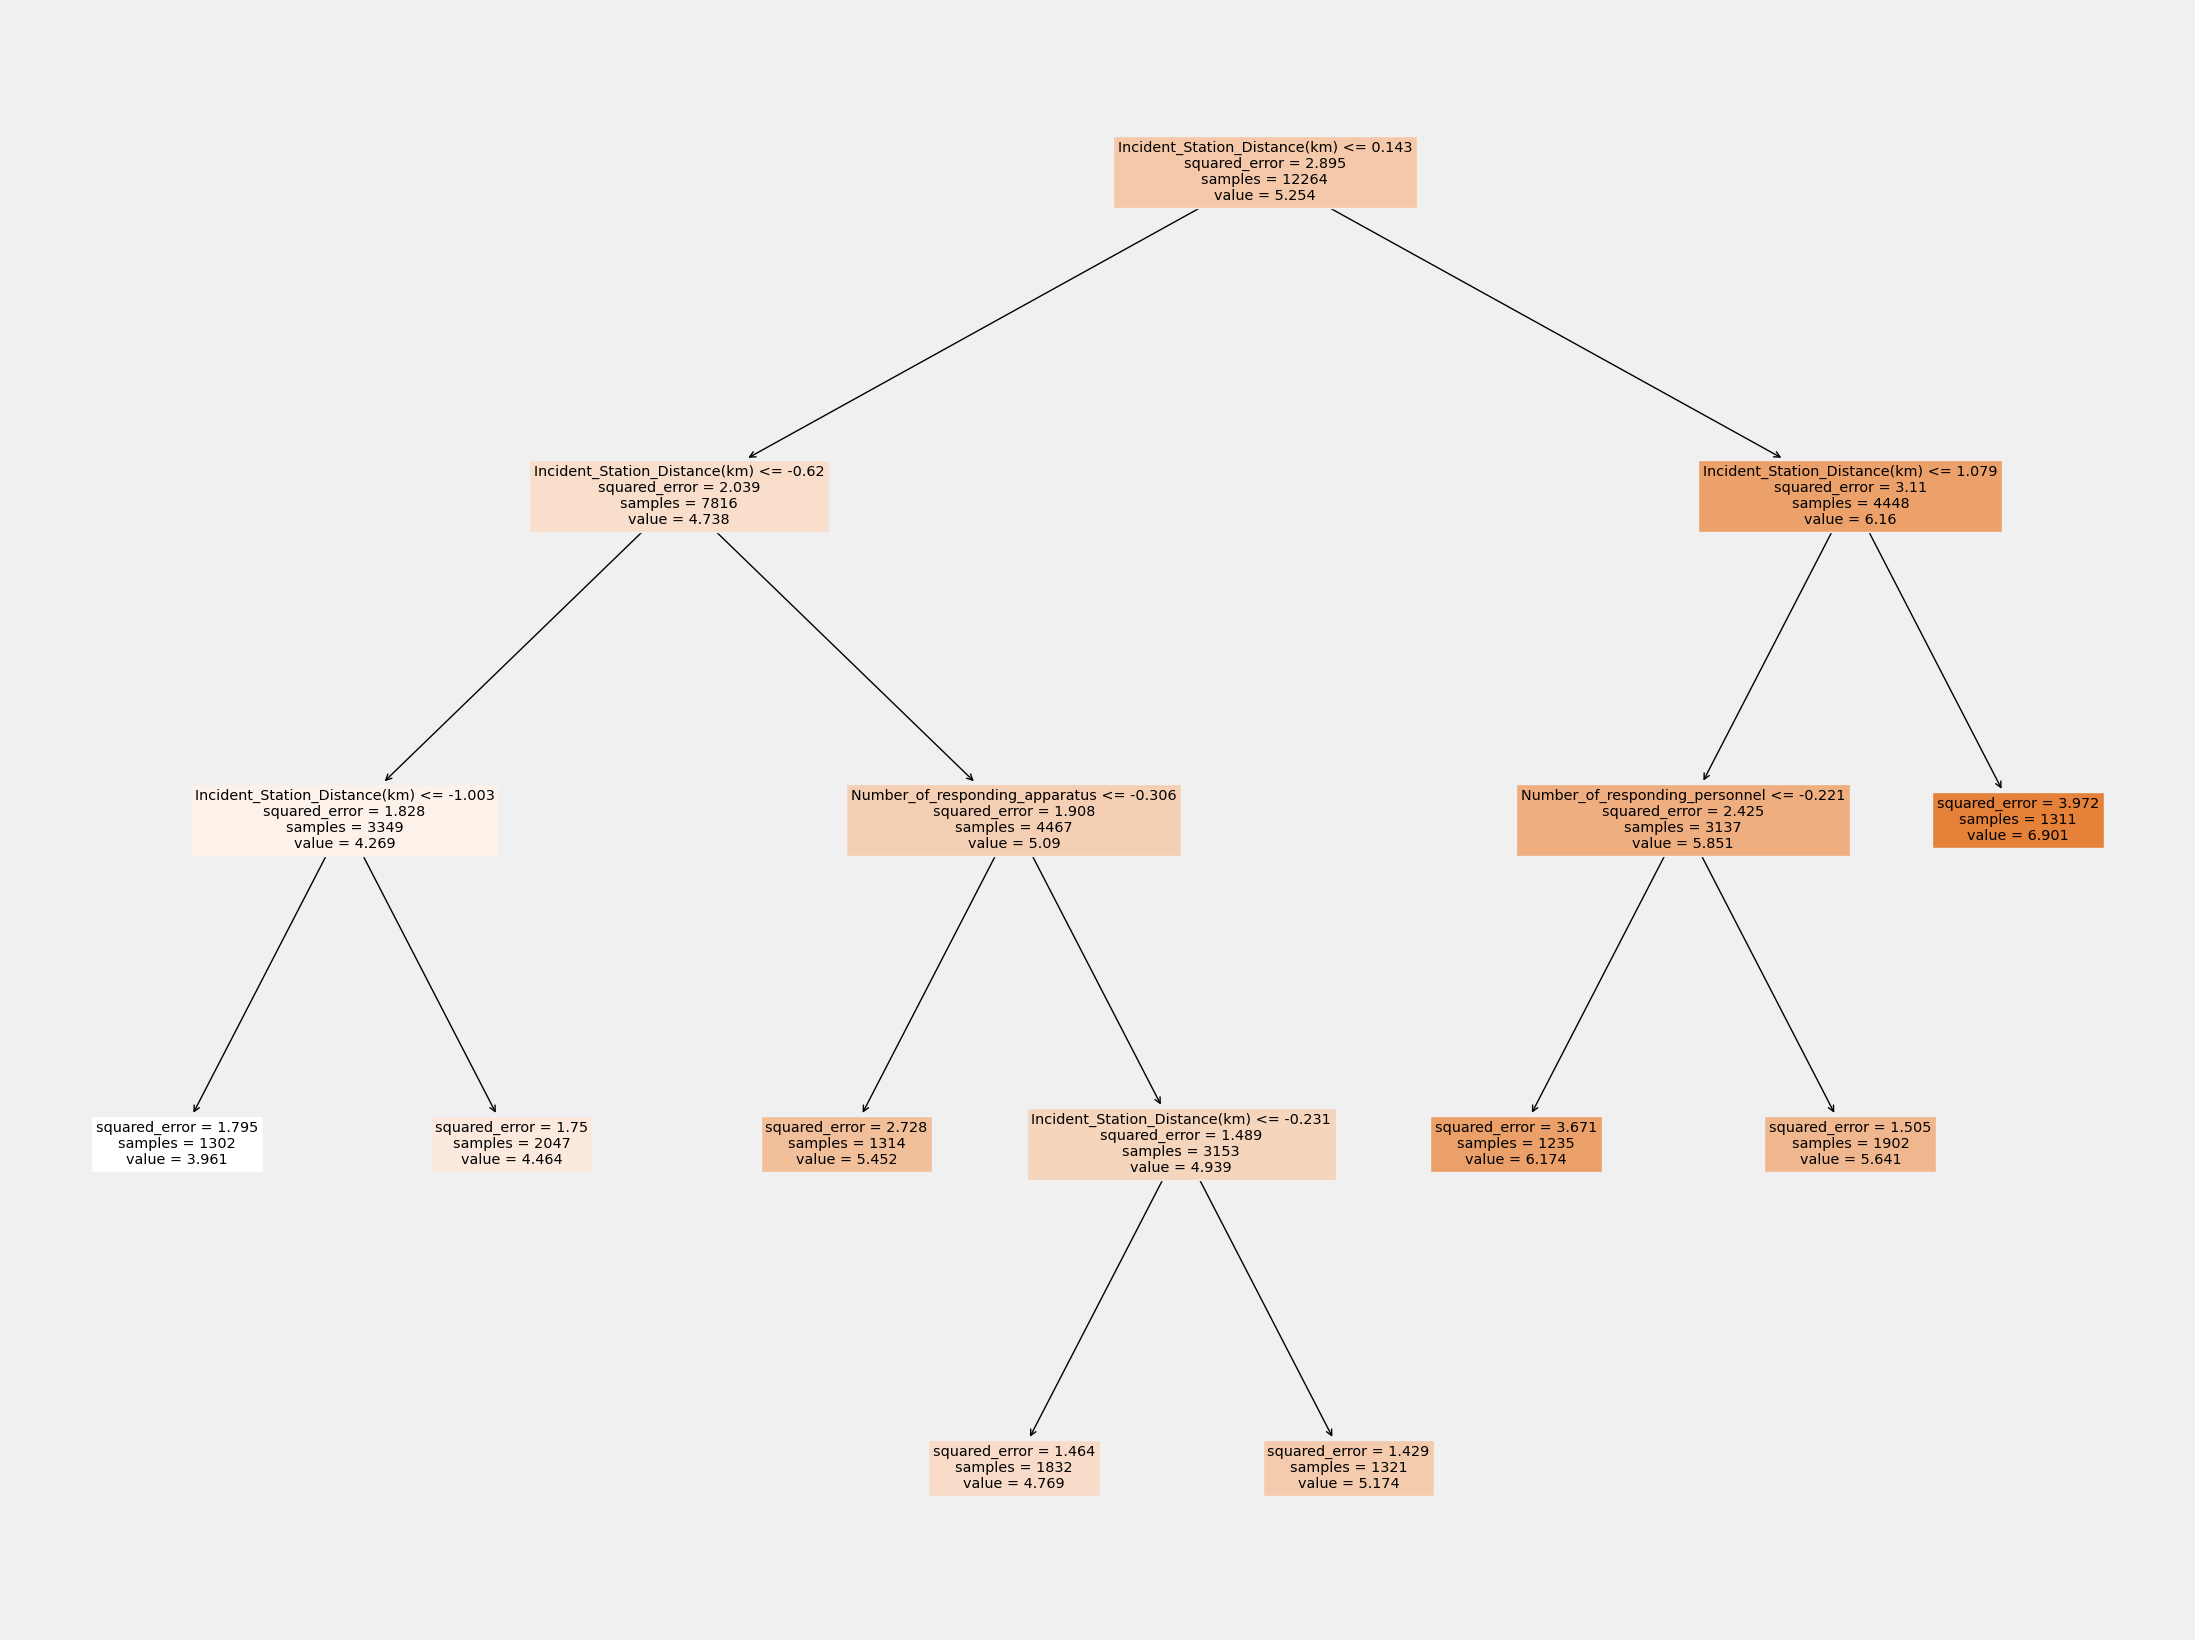

In [79]:
# Visualize the tree
from sklearn import tree
fig = plt.figure(figsize=(25,20))
features = ['Incident_Station_Distance(km)','Hour', 'on_peak_hours', 'Number_of_responding_personnel', 'Number_of_responding_apparatus']
_ = tree.plot_tree(reg, 
                   feature_names=features,  
                   class_names=y_test,
                   filled=True)

# Discarded Codes for Now

## Splitting "## - Description Columns"
Below I created a function that could take in the columns with the format "## - Description" and split them into two separate columns: one for the number and one for the text.

I tested it and it works, but I think we should wait to apply this to our DataFrame until we have selected the columns we are interested in because this function will almost double the number of columns we have.

In [ ]:
def column_split(df, column, number_column, string_column):

    df[number_column], df[string_column] = df[column].str.split('-', 1).str

    return df[number_column], df[string_column]

In [ ]:
# column_split(fire_data, 'Area_of_Origin', 'Area_Of_Origin_No', 'Area_Of_Origin_Descr')
# fire_data

In [ ]:
#helper function to evaluate a model

def evaluate_model(model, model_name = None):
    model.fit(X_train,y_train)
    pred = model.predict(X_val)
    error = mean_squared_error(y_val, pred)
    if model_name is not None:
        print("Error for %s, : %.6f"%(model_name, error))
    return error

In [ ]:
fire_data[fire_data['Year'] == 2017]['Incident_Ward'].unique()

array([ 2.,  4., 11.,  3., 24., 16., 40., 25., 34., 37., 35., 38., 12.,
       15.,  0., 10., 44., 31., 26., 36., 43., 27., 20., 28., 14., 18.,
       30., 32., 17., 21., 39., 33.,  8.,  9.,  5., 19.,  1., 22.,  6.,
       13., 23., 42.,  7., 29., 41.])

## Category 1 Data: Data with ~36% of data missing

Select columns with a high proportion (~36%) of null values. Most of these features have the exact same number of null values and relate to the presence of a fire alarm.

In [ ]:
category_1 = []
for column in fire_data.columns:
    if fire_data[column].isnull().sum() >6000:
        category_1.append(column)
       # print(column + ' Unique Values: ' + str(fire_data[column].unique()))

category_1

[]

 The following features are obviously related to the presence of a smoke/fire alarm:
 ['Fire_Alarm_System_Impact_on_Evacuation',
 'Fire_Alarm_System_Operation',
 'Fire_Alarm_System_Presence',
 'Smoke_Alarm_at_Fire_Origin',
 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
 'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
 'Smoke_Spread',
 'Sprinkler_System_Operation',
 'Sprinkler_System_Presence']

We care about all fires, not just ones where a smoke alarm was present. There are four categories under 'Fire_Alarm_System_Presence':

Since there are already categories for whether or not a smoke alarm is present, we can't just assume that a blank row means there was no alarm. Instead, we can decide to use code '10 - No ' to indicate we do not know. There might be another feature that explains why these rows are empty. Let's start by looking at all the other features in rows where Fire_Alarm_System_Presence is null:

In [ ]:
# #initialize new column indicating whether Fire_Alarm_System_Presence is null
# fire_data['null_fire_alarm_system'] = fire_data['Fire_Alarm_System_Presence'].isnull()

We can check whether the other columns are dependent on null_fire_system_alarm using a chi squared test. If pvalue < 0.05, the columns might be dependent on the null, and therefore might help us explain what's going on with all this missing data.

In [ ]:
# cols_related_fire_alarm = []
#
# for column in fire_data.columns:
#     chisqt = pd.crosstab(fire_data['null_fire_alarm_system'], fire_data[column], margins=True)
#     value = np.array([chisqt.iloc[0][0:5].values,
#                       chisqt.iloc[1][0:5].values])
#     p_score = chi2_contingency(value)[1]
#     if p_score < 0.05:
#         cols_related_fire_alarm.append(column)
#         print(column)
#         print(chi2_contingency(value)[0:3])

Now let's look at the types of values we get in these low p-value features when fire_alarm_system_presence is null

In [ ]:
# for column in cols_related_fire_alarm:
#     print(column)
#     print(fire_data[fire_data['Fire_Alarm_System_Presence'].isnull()][column].unique())

This isn't too helpful! There are a lot of categories in each of these columns and it's hard to distinguish which ones are actually related to whether fire_alarm_system_presence is null. Stopping here (Jeff, Nov 23) I think it's probably best to just assign these rows something like "undetermined"

fire_data[category_1].fillna('Undetermined')

In addition to null values, some columns have data that includes "undetermined", "not applicable", or something related. It would be useful to explore these. An example is below.

In [ ]:
# fire_data.groupby('Smoke_Spread').size().sort_values(ascending = False)

One thing we noticed is that some of this fire incidents data does not actually pertain to fire incidents. Fire trucks typically respond to the scene in non-fire emergencies like medical. It would be useful for us to explore how much of this data does not actually pertain to fires. Perhaps this will allow us to reason why there are specific groupings of null values.

"Initial_CAD_Event_Type" appears to be the column that tells us what each call is for. There are 115 unique values in this column. Let's look at what they are.

UPDATE: It is very difficult to tell what some of the abbreviations in this column mean (e.g., VEF, FIHR, FICI, FIG, etc.) for now I will move on to other data cleaning until we find a document that will help us with this. If we cannot find documentation - @Jeff something your Dad could help with?

In [ ]:
# fire_data['Initial_CAD_Event_Type'].nunique()

In [ ]:
# fire_data.groupby('Final_Incident_Type').size().sort_values(ascending = False).head()

In [ ]:
# fire_data.groupby('Initial_CAD_Event_Type').size().sort_values(ascending = False).head(20)

In [ ]:
# fig, axes = plt.subplots(1,2,figsize =(20,10))
#
# sns.countplot(x='Year', data=fire_data,hue = 'Count_of_Persons_Rescued', palette='viridis', ax=axes[0])
# axes[0].set_title('People Rescued', size=20)
#
# sns.countplot(x='Year', data=fire_data,hue='Civilian_Casualties', palette='viridis', ax=axes[1])
# axes[1].set_title('Civilian Casulaties', size=20)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
#
# sns.despine(bottom=False, left=True)

In [ ]:
# fire_data['Civilian_Casualties'].value_counts().head(40).to_frame(name='Counts').reset_index().style.background_gradient(cmap='Reds', subset='Counts')

In [ ]:
# sns.countplot(x = 'Year',data = fire_data, hue ='TFS_Firefighter_Casualties', palette = 'viridis')


In [ ]:
### Important Data! Identify Sation 426- near parkdale? Why is this station respondong most? close to most incidents?

In [ ]:
# fire_data['Incident_Station_Area'].value_counts().head().to_frame(name='Count').reset_index().style.background_gradient(cmap='Reds', subset='Count')

In [ ]:
# property_count = fire_data['Property_Use'].value_counts()
# property_count = property_count[:10]
# plt.figure(figsize = (20,10))
# sns.barplot(x=property_count.index,y=property_count.values, alpha=0.8, palette='cividis')
# plt.title('Top Property Use for Incidents', fontsize = 30)
# plt.xlabel('Property Use', fontsize = 20)
# plt.ylabel('Incidents', fontsize = 20)
# plt.xticks(rotation = 90)
# plt.show()

In [ ]:
# fire_data['Property_Use'].value_counts()\
#                     .head()\
#                     .to_frame(name = 'Count')\
#                     .reset_index()\
#                     .style.background_gradient(cmap = 'Reds', subset='Count')

In [ ]:
# fire_data['Material_First_Ignited'].value_counts()\
#                             .head(20)\
#                             .to_frame(name='Count')\
#                             .reset_index()\
#                             .style.background_gradient(cmap='Reds', subset='Count')

In [ ]:
# material_count = fire_data['Material_First_Ignited'].value_counts()
# material_count = material_count[:10]
# plt.figure(figsize = (20,10))
# sns.barplot(x=material_count.index,y=material_count.values, alpha=0.8, saturation =1, palette='cividis')
# plt.title('Top Material first ignited for Incidents', fontsize = 30)
# plt.xlabel('Material', fontsize = 20)
# plt.ylabel('Incidents', fontsize = 20)
# plt.xticks(rotation = 90)
# plt.show()